# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, save, load
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('dom.xlsx')
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})
dom.drop('seat', axis = 1, inplace = True)

In [4]:
dom.head()

,ds,y
0,2015-01-01,"52,356"
1,2015-01-02,"47,811"
2,2015-01-03,"49,555"
3,2015-01-04,"57,680"
4,2015-01-05,"50,193"


In [5]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3012 non-null   datetime64[ns]
 1   y       3012 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 47.2 KB


<AxesSubplot:xlabel='ds'>

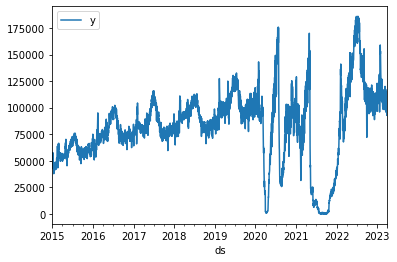

In [6]:
dom.set_index('ds').plot()

In [7]:
holidays = pd.read_excel('holidays2.xlsx')

In [8]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

# 2. Build models

## 2.1. Neural prophet

In [9]:
train = dom[dom['ds'] < '2022-07-01'].copy()
val = dom[(dom['ds'] >= '2022-07-01')&(dom['ds'] < '2023-01-01')].copy()
test = dom[dom['ds'] >= '2023-01-01'].copy()

In [10]:
holidays = holidays.rename(columns={'holiday': 'event'})
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [11]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,100),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 100),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,40),
        'n_lags':trial.suggest_int('n_lags',1,365),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,10),
        'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,3),
        'loss_func':trial.suggest_categorical('loss_func',['Huber', 'MAE'])
    }
    events_params_1 = {'regularization':trial.suggest_float('event1_regularization',0,0.2),
                      'mode':trial.suggest_categorical('event1_mode',['multiplicative', 'additive'])}
    events_params_2 = {'regularization':trial.suggest_float('event2_regularization',0,0.2),
                      'mode':trial.suggest_categorical('event2_mode',['multiplicative', 'additive'])}  
    
    # Create the model
    optuna_model = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)  
    optuna_model.add_events(events = ['Lunar','Labor','Summer','new_year'], **events_params_2)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="D")

    # Make predictions
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays)
    optuna_forecast = optuna_model.predict(df=future_df)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [12]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-04-25 15:34:27,601] A new study created in memory with name: no-name-8f349bb7-af70-46d7-b476-215e3234196a


In [13]:
study.optimize(objective, n_trials=300)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 152


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:37:15,870] Trial 0 finished with value: 41781.0 and parameters: {'trend_reg': 67.22818358452055, 'seasonality_reg': 48.85903208413432, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 23, 'n_lags': 109, 'ar_reg': 0.46695720506953253, 'learning_rate': 9.906283367308491, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.07548778726699304, 'event1_mode': 'additive', 'event2_regularization': 0.07909080886916407, 'event2_mode': 'multiplicative'}. Best is trial 0 with value: 41781.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:39:54,164] Trial 1 finished with value: 120206.0 and parameters: {'trend_reg': 9.362215716681959, 'seasonality_reg': 81.34951043693468, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 33, 'n_lags': 303, 'ar_reg': 2.215773717295777, 'learning_rate': 6.448702181331513, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.028802199781536933, 'event1_mode': 'additive', 'event2_regularization': 0.015522767320002974, 'event2_mode': 'multiplicative'}. Best is trial 0 with value: 41781.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNIN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:42:42,665] Trial 2 finished with value: 38124.0 and parameters: {'trend_reg': 89.86452006305291, 'seasonality_reg': 55.26821924507856, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 2, 'n_lags': 192, 'ar_reg': 6.401425405143248, 'learning_rate': 8.00678097830046, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.09324762694196845, 'event1_mode': 'additive', 'event2_regularization': 0.07546675744907937, 'event2_mode': 'additive'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forec

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:46:19,471] Trial 3 finished with value: 67880.0 and parameters: {'trend_reg': 93.91780311110828, 'seasonality_reg': 83.76560989826794, 'seasonality_mode': 'additive', 'yearly_seasonality': 36, 'weekly_seasonality': 4, 'n_lags': 150, 'ar_reg': 6.415701007734636, 'learning_rate': 9.764536770846385, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.05861302258677808, 'event1_mode': 'additive', 'event2_regularization': 0.1437012759555653, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:50:41,009] Trial 4 finished with value: 47600.0 and parameters: {'trend_reg': 31.260133180501843, 'seasonality_reg': 4.986377428906286, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 37, 'n_lags': 56, 'ar_reg': 4.700286207548979, 'learning_rate': 5.463140085069839, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04705330788557452, 'event1_mode': 'additive', 'event2_regularization': 0.04873126080603332, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:53:22,048] Trial 5 finished with value: 62948.0 and parameters: {'trend_reg': 69.103296834964, 'seasonality_reg': 35.544821127851655, 'seasonality_mode': 'additive', 'yearly_seasonality': 15, 'weekly_seasonality': 10, 'n_lags': 199, 'ar_reg': 3.5491121674008, 'learning_rate': 7.4467278727058765, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.10531726780819961, 'event1_mode': 'additive', 'event2_regularization': 0.021324673976366528, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (N

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:55:51,594] Trial 6 finished with value: 146677.0 and parameters: {'trend_reg': 50.70844456824804, 'seasonality_reg': 80.70697372251932, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 4, 'n_lags': 265, 'ar_reg': 7.513537114521935, 'learning_rate': 6.150779062696199, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.16964653710656954, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1545161040649919, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:58:51,199] Trial 7 finished with value: 50917.0 and parameters: {'trend_reg': 68.9534708091899, 'seasonality_reg': 24.988820481837102, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 25, 'n_lags': 223, 'ar_reg': 7.030933274614392, 'learning_rate': 0.7698121462569356, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.13152312881814884, 'event1_mode': 'additive', 'event2_regularization': 0.16821258028351935, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:03:10,576] Trial 8 finished with value: 32780.0 and parameters: {'trend_reg': 94.75551283222595, 'seasonality_reg': 23.252949089536482, 'seasonality_mode': 'additive', 'yearly_seasonality': 11, 'weekly_seasonality': 32, 'n_lags': 53, 'ar_reg': 0.8649102197078118, 'learning_rate': 8.189965889533655, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.18737720663589708, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14145658079252127, 'event2_mode': 'additive'}. Best is trial 8 with value: 32780.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:08:05,488] Trial 9 finished with value: 31944.0 and parameters: {'trend_reg': 71.31326582278776, 'seasonality_reg': 71.52906292230175, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 38, 'n_lags': 269, 'ar_reg': 1.6447437009756782, 'learning_rate': 0.6660012473263757, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04846931473930989, 'event1_mode': 'additive', 'event2_regularization': 0.031720665408139295, 'event2_mode': 'additive'}. Best is trial 9 with value: 31944.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:12:29,460] Trial 10 finished with value: 17754.0 and parameters: {'trend_reg': 33.74158671683395, 'seasonality_reg': 61.59187591533609, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 40, 'n_lags': 365, 'ar_reg': 2.8427833740002195, 'learning_rate': 0.34793658931291116, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.008124477189068537, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10601485615663699, 'event2_mode': 'additive'}. Best is trial 10 with value: 17754.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:16:02,782] Trial 11 finished with value: 53295.0 and parameters: {'trend_reg': 26.185353056391456, 'seasonality_reg': 61.27236174947568, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 38, 'n_lags': 365, 'ar_reg': 9.828700985903964, 'learning_rate': 0.1538372328891947, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.010987509665710805, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11136280404881041, 'event2_mode': 'additive'}. Best is trial 10 with value: 17754.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:18:55,696] Trial 12 finished with value: 15470.0 and parameters: {'trend_reg': 45.12190165078739, 'seasonality_reg': 99.77232465798588, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 30, 'n_lags': 358, 'ar_reg': 2.7193032660527474, 'learning_rate': 2.688742419054353, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0018828693336962275, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19462179002378102, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:22:01,529] Trial 13 finished with value: 16086.0 and parameters: {'trend_reg': 37.29710535208028, 'seasonality_reg': 98.54122803353296, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 29, 'n_lags': 361, 'ar_reg': 3.1393711094477856, 'learning_rate': 3.286501111364959, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0009104492776905587, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19049640005704796, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:25:34,166] Trial 14 finished with value: 15679.0 and parameters: {'trend_reg': 46.75671085719201, 'seasonality_reg': 99.48789562850142, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 29, 'n_lags': 316, 'ar_reg': 3.9798187210065397, 'learning_rate': 3.1657348701294348, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0033611997935397817, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18124176708792927, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:28:30,574] Trial 15 finished with value: 23085.0 and parameters: {'trend_reg': 50.90519520129375, 'seasonality_reg': 99.44709749008177, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 21, 'n_lags': 304, 'ar_reg': 4.866093731012793, 'learning_rate': 3.4935056371293722, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.03480902163972837, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1893031591703921, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:31:17,259] Trial 16 finished with value: 44657.0 and parameters: {'trend_reg': 10.921968329199338, 'seasonality_reg': 87.82418839348465, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 17, 'n_lags': 316, 'ar_reg': 4.143617806504593, 'learning_rate': 3.1522881974759764, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.12698254392810995, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19975724219594906, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:33:36,845] Trial 17 finished with value: 65284.0 and parameters: {'trend_reg': 57.5362081346305, 'seasonality_reg': 91.8041508096951, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 16, 'n_lags': 249, 'ar_reg': 5.505856095638787, 'learning_rate': 2.471509894460563, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.02376498105293466, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12368261708130701, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:36:47,000] Trial 18 finished with value: 30595.0 and parameters: {'trend_reg': 20.340398086179825, 'seasonality_reg': 70.0441695534613, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 27, 'n_lags': 8, 'ar_reg': 1.6144466708447451, 'learning_rate': 1.7806425040343736, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.07593923243099203, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17108919545477333, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:39:38,062] Trial 19 finished with value: 24095.0 and parameters: {'trend_reg': 41.946013986224784, 'seasonality_reg': 73.24841554191774, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 30, 'n_lags': 322, 'ar_reg': 8.577592391695315, 'learning_rate': 4.326378721877546, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.06643440647133814, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17108371799736866, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:42:34,604] Trial 20 finished with value: 26316.0 and parameters: {'trend_reg': 78.59869686280095, 'seasonality_reg': 41.00518052506988, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 17, 'n_lags': 145, 'ar_reg': 3.7613094035386814, 'learning_rate': 1.7738909235362859, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.023108409749455723, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1295528866032248, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:46:34,146] Trial 21 finished with value: 15576.0 and parameters: {'trend_reg': 41.502293789111505, 'seasonality_reg': 98.67854105157876, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 29, 'n_lags': 341, 'ar_reg': 2.7851941637466266, 'learning_rate': 4.320743231829304, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0015805490619240693, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18396705277083109, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:50:05,102] Trial 22 finished with value: 15956.0 and parameters: {'trend_reg': 44.30028396446876, 'seasonality_reg': 94.77957424492605, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 35, 'n_lags': 327, 'ar_reg': 2.011242762242216, 'learning_rate': 4.634404471248256, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0012296664653713937, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17782680963736197, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:53:08,203] Trial 23 finished with value: 21130.0 and parameters: {'trend_reg': 58.20653906756026, 'seasonality_reg': 90.37263033668373, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 27, 'n_lags': 286, 'ar_reg': 2.7615305515731223, 'learning_rate': 4.3024983517059825, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.03864504652686204, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15880176414975627, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:56:19,654] Trial 24 finished with value: 20886.0 and parameters: {'trend_reg': 18.84973945146696, 'seasonality_reg': 98.75702034488059, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 33, 'n_lags': 343, 'ar_reg': 5.675000488674873, 'learning_rate': 1.9297349980622853, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.018697793705709124, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19623143687214653, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:00:52,355] Trial 25 finished with value: 15962.0 and parameters: {'trend_reg': 58.2697676668589, 'seasonality_reg': 74.99357807703862, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 23, 'n_lags': 240, 'ar_reg': 0.015517462942853832, 'learning_rate': 3.6968513421259974, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.00012136522743145888, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15261122008878195, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:06:00,377] Trial 26 finished with value: 72905.0 and parameters: {'trend_reg': 43.37953993889832, 'seasonality_reg': 86.51906016068904, 'seasonality_mode': 'additive', 'yearly_seasonality': 23, 'weekly_seasonality': 30, 'n_lags': 338, 'ar_reg': 4.055651194641908, 'learning_rate': 2.570206412853679, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.04440931723209775, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18207818363879977, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:10:25,209] Trial 27 finished with value: 45570.0 and parameters: {'trend_reg': 1.2236446206681322, 'seasonality_reg': 91.67529627121365, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 27, 'n_lags': 287, 'ar_reg': 2.3562147946901564, 'learning_rate': 5.561622137772644, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.018103187502249336, 'event1_mode': 'multiplicative', 'event2_regularization': 0.08513284025199382, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:14:50,317] Trial 28 finished with value: 43641.0 and parameters: {'trend_reg': 27.379273516467173, 'seasonality_reg': 80.53003402510934, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 37, 'weekly_seasonality': 20, 'n_lags': 220, 'ar_reg': 1.1045966478870501, 'learning_rate': 1.342842249214341, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.14966712418785194, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13223503870368325, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:17:12,503] Trial 29 finished with value: 37483.0 and parameters: {'trend_reg': 61.47583336594594, 'seasonality_reg': 65.03493076851245, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 24, 'n_lags': 338, 'ar_reg': 3.3118818164085146, 'learning_rate': 5.164201626924605, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.06612767621800458, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1623837344653578, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:22:05,196] Trial 30 finished with value: 33814.0 and parameters: {'trend_reg': 47.56843010119112, 'seasonality_reg': 50.21522432091028, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 35, 'n_lags': 286, 'ar_reg': 4.526764471169277, 'learning_rate': 2.4680913454756794, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.08184181420782685, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19929232954308748, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:26:53,427] Trial 31 finished with value: 16147.0 and parameters: {'trend_reg': 42.79345037414349, 'seasonality_reg': 94.03630167614449, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 36, 'n_lags': 330, 'ar_reg': 2.1762700636216916, 'learning_rate': 4.195905269614631, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0011505757311052465, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17926566137192376, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:30:23,112] Trial 32 finished with value: 18404.0 and parameters: {'trend_reg': 37.29144069618098, 'seasonality_reg': 99.17647947694826, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 34, 'n_lags': 304, 'ar_reg': 1.2092850960715076, 'learning_rate': 4.657507792792914, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.020718833877642753, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18065921962752537, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.86% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.86% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:33:33,364] Trial 33 finished with value: 22130.0 and parameters: {'trend_reg': 51.67235794030394, 'seasonality_reg': 79.64808773705992, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 32, 'n_lags': 347, 'ar_reg': 2.072252075167547, 'learning_rate': 3.715689497520587, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.03435443679101013, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1811192409496477, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:36:32,995] Trial 34 finished with value: 51073.0 and parameters: {'trend_reg': 45.34664980349383, 'seasonality_reg': 93.17508117817205, 'seasonality_mode': 'additive', 'yearly_seasonality': 35, 'weekly_seasonality': 29, 'n_lags': 312, 'ar_reg': 2.585868762363384, 'learning_rate': 6.105027387876753, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.012489559489716761, 'event1_mode': 'multiplicative', 'event2_regularization': 0.000608034173711608, 'event2_mode': 'multiplicative'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:39:12,746] Trial 35 finished with value: 44858.0 and parameters: {'trend_reg': 37.0159423141222, 'seasonality_reg': 85.69744368705125, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 31, 'n_lags': 153, 'ar_reg': 3.4482946671846837, 'learning_rate': 7.050501996754326, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.03044239083605144, 'event1_mode': 'additive', 'event2_regularization': 0.14699514006463288, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:42:15,864] Trial 36 finished with value: 72264.0 and parameters: {'trend_reg': 63.09128180842467, 'seasonality_reg': 1.8651799284614086, 'seasonality_mode': 'additive', 'yearly_seasonality': 36, 'weekly_seasonality': 34, 'n_lags': 279, 'ar_reg': 0.5962782686170378, 'learning_rate': 2.86633269776468, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.05573377589772538, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0668033875266071, 'event2_mode': 'multiplicative'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:45:00,962] Trial 37 finished with value: 69976.0 and parameters: {'trend_reg': 53.03677025060711, 'seasonality_reg': 77.6172332830431, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 26, 'n_lags': 318, 'ar_reg': 1.6567157937109906, 'learning_rate': 4.862055567966226, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.09803045156935745, 'event1_mode': 'additive', 'event2_regularization': 0.17046726719240562, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:47:40,809] Trial 38 finished with value: 67523.0 and parameters: {'trend_reg': 74.73699746761935, 'seasonality_reg': 94.2174228870799, 'seasonality_mode': 'additive', 'yearly_seasonality': 27, 'weekly_seasonality': 40, 'n_lags': 259, 'ar_reg': 5.662827469320316, 'learning_rate': 5.662027201462555, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.009875140194178145, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1874830482009294, 'event2_mode': 'multiplicative'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:50:28,109] Trial 39 finished with value: 46297.0 and parameters: {'trend_reg': 80.45562413289028, 'seasonality_reg': 85.28558205767918, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 22, 'n_lags': 345, 'ar_reg': 4.216334934481464, 'learning_rate': 3.8858558770533143, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.10990661679966644, 'event1_mode': 'additive', 'event2_regularization': 0.14048816260847904, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.785% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.785% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:53:02,294] Trial 40 finished with value: 21799.0 and parameters: {'trend_reg': 25.205298713877145, 'seasonality_reg': 13.2873989191284, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 9, 'n_lags': 100, 'ar_reg': 0.11060181418660764, 'learning_rate': 6.605595087227346, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.029855928777462588, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1610711636562617, 'event2_mode': 'multiplicative'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:55:47,923] Trial 41 finished with value: 15369.0 and parameters: {'trend_reg': 55.19197845354596, 'seasonality_reg': 74.8349317428687, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 24, 'n_lags': 238, 'ar_reg': 0.10081199427565565, 'learning_rate': 3.796151537875456, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.003608785921599711, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1477535519499768, 'event2_mode': 'additive'}. Best is trial 41 with value: 15369.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:58:55,079] Trial 42 finished with value: 15955.0 and parameters: {'trend_reg': 40.32892888625268, 'seasonality_reg': 95.42682039356937, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'weekly_seasonality': 28, 'n_lags': 225, 'ar_reg': 2.04081400963394, 'learning_rate': 2.959144040589024, 'num_hidden_layers': 3, 'loss_func': 'Huber', 'event1_regularization': 0.008395315639346588, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17199535053843915, 'event2_mode': 'additive'}. Best is trial 41 with value: 15369.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:01:49,085] Trial 43 finished with value: 17399.0 and parameters: {'trend_reg': 64.77728804415418, 'seasonality_reg': 83.59203485539572, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 19, 'n_lags': 208, 'ar_reg': 2.973055947765155, 'learning_rate': 2.849464091482736, 'num_hidden_layers': 3, 'loss_func': 'Huber', 'event1_regularization': 0.013235533672951319, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16434204826021956, 'event2_mode': 'additive'}. Best is trial 41 with value: 15369.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:04:58,301] Trial 44 finished with value: 17296.0 and parameters: {'trend_reg': 54.628123770024175, 'seasonality_reg': 88.37077849276972, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'weekly_seasonality': 28, 'n_lags': 241, 'ar_reg': 0.6408494809674044, 'learning_rate': 1.3031349483478807, 'num_hidden_layers': 3, 'loss_func': 'Huber', 'event1_regularization': 0.008840296903087927, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11744022595370608, 'event2_mode': 'additive'}. Best is trial 41 with value: 15369.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:08:01,569] Trial 45 finished with value: 12989.0 and parameters: {'trend_reg': 39.81214178347944, 'seasonality_reg': 96.69408162873742, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 24, 'n_lags': 191, 'ar_reg': 1.3961265243853365, 'learning_rate': 2.1538672224542688, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.025584112276280963, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15088919949051827, 'event2_mode': 'additive'}. Best is trial 45 with value: 12989.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.803% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.803% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:10:48,051] Trial 46 finished with value: 43493.0 and parameters: {'trend_reg': 31.220696145489562, 'seasonality_reg': 55.17699781137928, 'seasonality_mode': 'additive', 'yearly_seasonality': 30, 'weekly_seasonality': 25, 'n_lags': 142, 'ar_reg': 1.2531784162888915, 'learning_rate': 8.898630512413565, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.024390047143062032, 'event1_mode': 'additive', 'event2_regularization': 0.15100949935544722, 'event2_mode': 'additive'}. Best is trial 45 with value: 12989.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (N

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:13:26,564] Trial 47 finished with value: 12753.0 and parameters: {'trend_reg': 48.6384996239202, 'seasonality_reg': 68.39064956979382, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 24, 'n_lags': 183, 'ar_reg': 1.5997114355971578, 'learning_rate': 2.2787588610774887, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04195659650099474, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13634784492439875, 'event2_mode': 'additive'}. Best is trial 47 with value: 12753.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:16:11,269] Trial 48 finished with value: 12564.0 and parameters: {'trend_reg': 32.61868866198339, 'seasonality_reg': 65.6099813074686, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 24, 'n_lags': 176, 'ar_reg': 0.4644503632150645, 'learning_rate': 2.178725929651104, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045588062564075604, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10257294550934012, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:18:53,036] Trial 49 finished with value: 16378.0 and parameters: {'trend_reg': 32.540682083788994, 'seasonality_reg': 66.86879672951663, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 24, 'n_lags': 181, 'ar_reg': 0.38109877048335505, 'learning_rate': 1.0270106783326671, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.050884727912660015, 'event1_mode': 'multiplicative', 'event2_regularization': 0.08439700617685535, 'event2_mode': 'multiplicative'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:21:21,671] Trial 50 finished with value: 57684.0 and parameters: {'trend_reg': 48.5091484728472, 'seasonality_reg': 55.01585406173125, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 189, 'ar_reg': 0.7376184892879626, 'learning_rate': 0.5845984931326547, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04180342934546736, 'event1_mode': 'additive', 'event2_regularization': 0.107047766867755, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:24:00,843] Trial 51 finished with value: 17093.0 and parameters: {'trend_reg': 38.01375148540858, 'seasonality_reg': 62.289482920562016, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 22, 'n_lags': 176, 'ar_reg': 1.5760784415380904, 'learning_rate': 2.361943039870654, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06203856051137273, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13556531611542783, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:26:41,486] Trial 52 finished with value: 12816.0 and parameters: {'trend_reg': 28.785866571714557, 'seasonality_reg': 68.44733548377941, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 19, 'n_lags': 162, 'ar_reg': 1.2525794348764627, 'learning_rate': 2.0468919136489037, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.02853803312205272, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10052591036974368, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:29:23,407] Trial 53 finished with value: 13803.0 and parameters: {'trend_reg': 22.35862516300762, 'seasonality_reg': 70.47309951091898, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 19, 'n_lags': 164, 'ar_reg': 1.0545918861709564, 'learning_rate': 2.0374680102190874, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.053807674605230046, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09026497302403527, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:32:08,254] Trial 54 finished with value: 12820.0 and parameters: {'trend_reg': 18.081097566096304, 'seasonality_reg': 70.76637144615789, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 19, 'n_lags': 167, 'ar_reg': 0.9849844030738067, 'learning_rate': 2.019781702687627, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05068688444043763, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09733123207279033, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:34:46,155] Trial 55 finished with value: 19741.0 and parameters: {'trend_reg': 14.689779255070151, 'seasonality_reg': 67.73643498297169, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 13, 'n_lags': 164, 'ar_reg': 0.963871287517162, 'learning_rate': 1.8475144851312186, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.08667441134725712, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09867374950758075, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.799% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.799% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:37:27,249] Trial 56 finished with value: 16170.0 and parameters: {'trend_reg': 21.397329375942025, 'seasonality_reg': 42.53047105871481, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 19, 'n_lags': 133, 'ar_reg': 1.4131927275131086, 'learning_rate': 2.1533340104561995, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05327166954935642, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0977241591373623, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.794% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.794% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:40:04,932] Trial 57 finished with value: 27456.0 and parameters: {'trend_reg': 6.765536351975875, 'seasonality_reg': 49.95668793176053, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 18, 'n_lags': 120, 'ar_reg': 0.40104487122432664, 'learning_rate': 1.5039539145982124, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.07141501227461108, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07135128218787112, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:42:33,208] Trial 58 finished with value: 12677.0 and parameters: {'trend_reg': 28.859434252618478, 'seasonality_reg': 58.52992496004825, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 16, 'n_lags': 202, 'ar_reg': 0.9756028549478758, 'learning_rate': 1.1297806225337328, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04710873306632572, 'event1_mode': 'multiplicative', 'event2_regularization': 0.059271796789507225, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:44:55,300] Trial 59 finished with value: 57667.0 and parameters: {'trend_reg': 28.26841930102323, 'seasonality_reg': 58.00157538739402, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 14, 'n_lags': 199, 'ar_reg': 1.7711219107672849, 'learning_rate': 0.0075349859722435575, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045090322754799524, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0604370764153598, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:47:25,192] Trial 60 finished with value: 3544960.0 and parameters: {'trend_reg': 17.104973143627838, 'seasonality_reg': 60.0034171939003, 'seasonality_mode': 'additive', 'yearly_seasonality': 14, 'weekly_seasonality': 12, 'n_lags': 209, 'ar_reg': 0.7504107384525143, 'learning_rate': 0.95537123310604, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.04015497382201853, 'event1_mode': 'multiplicative', 'event2_regularization': 0.043407025462254445, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNIN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:50:12,255] Trial 61 finished with value: 17809.0 and parameters: {'trend_reg': 13.287044230706448, 'seasonality_reg': 69.83970585528792, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 16, 'n_lags': 162, 'ar_reg': 1.0035188050089237, 'learning_rate': 2.122493844364726, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05509283595787384, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09162904214382982, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:52:37,445] Trial 62 finished with value: 24535.0 and parameters: {'trend_reg': 22.8440176361574, 'seasonality_reg': 65.53496555104503, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 21, 'n_lags': 172, 'ar_reg': 1.276684469600743, 'learning_rate': 0.41142335572238675, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06148361232656713, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11738158626780852, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.787% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.787% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:55:13,518] Trial 63 finished with value: 12794.0 and parameters: {'trend_reg': 30.17482130344991, 'seasonality_reg': 71.02785450191428, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 20, 'n_lags': 105, 'ar_reg': 0.3067543019256451, 'learning_rate': 1.3723981198173543, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0367421938240717, 'event1_mode': 'multiplicative', 'event2_regularization': 0.05718702079488526, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 18:57:51,172] Trial 64 finished with value: 12677.0 and parameters: {'trend_reg': 30.37603930012956, 'seasonality_reg': 77.18595341055263, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 22, 'n_lags': 81, 'ar_reg': 0.3581770425007884, 'learning_rate': 1.4959682656125843, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03656805510848611, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0525011267848983, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.772% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.772% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:00:22,536] Trial 65 finished with value: 12828.0 and parameters: {'trend_reg': 29.534774087120212, 'seasonality_reg': 75.61369488443623, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 17, 'n_lags': 73, 'ar_reg': 0.37954320319557233, 'learning_rate': 1.5551774307047959, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03502353409137366, 'event1_mode': 'multiplicative', 'event2_regularization': 0.05157980812303392, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.778% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.778% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:03:00,077] Trial 66 finished with value: 16019.0 and parameters: {'trend_reg': 33.19788864397489, 'seasonality_reg': 63.85451956976847, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 22, 'n_lags': 86, 'ar_reg': 0.014509873815408802, 'learning_rate': 1.0545970751759877, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04717924777276171, 'event1_mode': 'multiplicative', 'event2_regularization': 0.030722162856970194, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.733% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.733% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:05:37,419] Trial 67 finished with value: 12998.0 and parameters: {'trend_reg': 35.081379647309085, 'seasonality_reg': 72.1728747771974, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 20, 'n_lags': 10, 'ar_reg': 0.48808208182438395, 'learning_rate': 0.8163468450967978, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03527368971204998, 'event1_mode': 'multiplicative', 'event2_regularization': 0.055077658743179554, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:08:24,884] Trial 68 finished with value: 19603.0 and parameters: {'trend_reg': 23.634891819269985, 'seasonality_reg': 58.69350559993018, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 21, 'n_lags': 54, 'ar_reg': 8.239441401131888, 'learning_rate': 1.2351475683390807, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07670169992492062, 'event1_mode': 'multiplicative', 'event2_regularization': 0.03985982462699218, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:10:55,634] Trial 69 finished with value: 31078.0 and parameters: {'trend_reg': 8.054954012116703, 'seasonality_reg': 78.28525945781945, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 35, 'ar_reg': 1.8476706083721128, 'learning_rate': 1.6547915551161811, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048487243743240406, 'event1_mode': 'multiplicative', 'event2_regularization': 0.062471135400955086, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.794% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.794% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:13:12,970] Trial 70 finished with value: 13429.0 and parameters: {'trend_reg': 16.086276401722188, 'seasonality_reg': 52.59788550378154, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 9, 'n_lags': 121, 'ar_reg': 0.9126911876599555, 'learning_rate': 3.4037415334038075, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.029169967419075224, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0803997220784842, 'event2_mode': 'multiplicative'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.772% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.772% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:15:43,262] Trial 71 finished with value: 12726.0 and parameters: {'trend_reg': 29.86353593937111, 'seasonality_reg': 75.94600363359817, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 17, 'n_lags': 73, 'ar_reg': 0.34363353424642507, 'learning_rate': 1.534154852109895, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03692435361346112, 'event1_mode': 'multiplicative', 'event2_regularization': 0.053505134050535814, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:18:15,063] Trial 72 finished with value: 21784.0 and parameters: {'trend_reg': 26.189462547446286, 'seasonality_reg': 68.45715559195983, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 17, 'n_lags': 81, 'ar_reg': 0.2886327981645311, 'learning_rate': 0.39045008305037787, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04000830613086117, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07191577211633941, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:20:46,062] Trial 73 finished with value: 13376.0 and parameters: {'trend_reg': 29.66015784105937, 'seasonality_reg': 72.42270335740827, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 18, 'n_lags': 96, 'ar_reg': 0.7305602360063636, 'learning_rate': 2.3942479978146047, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.017529202618537076, 'event1_mode': 'multiplicative', 'event2_regularization': 0.03310903409398556, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.767% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.767% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:23:09,698] Trial 74 finished with value: 30365.0 and parameters: {'trend_reg': 18.56638306175833, 'seasonality_reg': 82.26338439467298, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 11, 'n_lags': 64, 'ar_reg': 2.34742231951663, 'learning_rate': 1.4929398568467418, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.18241576671837811, 'event1_mode': 'multiplicative', 'event2_regularization': 0.02217146246723537, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.752% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.752% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:25:56,732] Trial 75 finished with value: 16325.0 and parameters: {'trend_reg': 35.10043568591577, 'seasonality_reg': 62.827287881340155, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 20, 'n_lags': 38, 'ar_reg': 0.2768359529451566, 'learning_rate': 0.5991680468378837, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0654454272758017, 'event1_mode': 'multiplicative', 'event2_regularization': 0.046441833608237934, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.793% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.793% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:28:37,521] Trial 76 finished with value: 46212.0 and parameters: {'trend_reg': 24.980370620404507, 'seasonality_reg': 77.38584804865127, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 23, 'n_lags': 117, 'ar_reg': 6.353694928502549, 'learning_rate': 1.8387654893341314, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.030862828928048747, 'event1_mode': 'additive', 'event2_regularization': 0.05383898435066434, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNIN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:31:28,584] Trial 77 finished with value: 13003.0 and parameters: {'trend_reg': 12.038738761601367, 'seasonality_reg': 46.698442929800095, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 26, 'n_lags': 134, 'ar_reg': 1.4452659010003508, 'learning_rate': 1.1701592842319968, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04379155794508037, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10490378421914098, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.786% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.786% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:34:14,651] Trial 78 finished with value: 39598.0 and parameters: {'trend_reg': 31.053649801882464, 'seasonality_reg': 73.90698362395217, 'seasonality_mode': 'additive', 'yearly_seasonality': 20, 'weekly_seasonality': 16, 'n_lags': 103, 'ar_reg': 0.6065749742173939, 'learning_rate': 2.6553078305650533, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.058498984677515166, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07673864189840869, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:36:48,039] Trial 79 finished with value: 12742.0 and parameters: {'trend_reg': 20.117278601860512, 'seasonality_reg': 66.11094608498286, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 18, 'n_lags': 151, 'ar_reg': 1.106987740091025, 'learning_rate': 0.7994837072564034, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.036983185314303973, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11669050900006234, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:38:57,662] Trial 80 finished with value: 1464157.0 and parameters: {'trend_reg': 27.335304815159105, 'seasonality_reg': 65.96572966608726, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 1, 'n_lags': 149, 'ar_reg': 1.8457068146383153, 'learning_rate': 0.22339007544894662, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03612949394141149, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11650369393417183, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:41:30,888] Trial 81 finished with value: 12852.0 and parameters: {'trend_reg': 34.421713906354235, 'seasonality_reg': 57.38040133493332, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 18, 'n_lags': 202, 'ar_reg': 1.1120447149287358, 'learning_rate': 0.7784721783677121, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.026677822704687514, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12485570353257935, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:43:59,479] Trial 82 finished with value: 17247.0 and parameters: {'trend_reg': 19.85145600208446, 'seasonality_reg': 68.87313997823537, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 15, 'n_lags': 184, 'ar_reg': 0.8362924364412876, 'learning_rate': 1.5073564364005685, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04819061329396218, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1104743097734167, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:46:45,755] Trial 83 finished with value: 12846.0 and parameters: {'trend_reg': 24.639179062570545, 'seasonality_reg': 60.87488444205948, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 22, 'n_lags': 216, 'ar_reg': 9.679633602770327, 'learning_rate': 2.3424220412802295, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.018939215277430595, 'event1_mode': 'multiplicative', 'event2_regularization': 0.06043813375925497, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:49:17,861] Trial 84 finished with value: 18565.0 and parameters: {'trend_reg': 5.388754520438319, 'seasonality_reg': 80.24752918910448, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 19, 'n_lags': 136, 'ar_reg': 0.0019181475860945985, 'learning_rate': 1.7450405315358735, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03285179785480268, 'event1_mode': 'multiplicative', 'event2_regularization': 0.040882644517736794, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:52:07,803] Trial 85 finished with value: 12600.0 and parameters: {'trend_reg': 28.882007838940076, 'seasonality_reg': 75.99106551205064, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 20, 'n_lags': 156, 'ar_reg': 0.6028348661856785, 'learning_rate': 3.02354073895575, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04436836772472254, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12374596496742066, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:54:40,418] Trial 86 finished with value: 13313.0 and parameters: {'trend_reg': 38.9714507840454, 'seasonality_reg': 76.26788000595039, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 21, 'n_lags': 159, 'ar_reg': 0.6031191278725812, 'learning_rate': 2.878371292875191, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.039991157897828686, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1260174311828238, 'event2_mode': 'multiplicative'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.779% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.779% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 19:57:34,770] Trial 87 finished with value: 12867.0 and parameters: {'trend_reg': 31.396525464152955, 'seasonality_reg': 64.19123749549759, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 26, 'n_lags': 88, 'ar_reg': 0.17925385172244646, 'learning_rate': 3.111879985552428, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.025799591126636913, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14014318346159496, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.79% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.79% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:00:17,382] Trial 88 finished with value: 19963.0 and parameters: {'trend_reg': 99.06798387914881, 'seasonality_reg': 74.06305005805649, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 23, 'n_lags': 112, 'ar_reg': 2.532281445596997, 'learning_rate': 1.389781716357135, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.015414523052931832, 'event1_mode': 'additive', 'event2_regularization': 0.1336946377294129, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:03:13,372] Trial 89 finished with value: 20928.0 and parameters: {'trend_reg': 36.48701199386075, 'seasonality_reg': 31.214917705665624, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 25, 'n_lags': 126, 'ar_reg': 1.2173832017328898, 'learning_rate': 0.8492560520881092, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.14076737875540996, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1130138833900303, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:05:56,207] Trial 90 finished with value: 104857.0 and parameters: {'trend_reg': 28.20037801544915, 'seasonality_reg': 81.57139202833682, 'seasonality_mode': 'additive', 'yearly_seasonality': 12, 'weekly_seasonality': 20, 'n_lags': 156, 'ar_reg': 1.5775312205708683, 'learning_rate': 1.2363683125104503, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.11107303627676754, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09005426054848902, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNIN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:08:40,848] Trial 91 finished with value: 12880.0 and parameters: {'trend_reg': 20.254950972709626, 'seasonality_reg': 71.925389834861, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 18, 'n_lags': 174, 'ar_reg': 0.8615087029883521, 'learning_rate': 2.004270436701504, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04992395894793544, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10181813746770242, 'event2_mode': 'additive'}. Best is trial 48 with value: 12564.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:11:18,667] Trial 92 finished with value: 12542.0 and parameters: {'trend_reg': 29.173112958619303, 'seasonality_reg': 68.03904083289808, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 171, 'ar_reg': 0.46586640211347063, 'learning_rate': 2.177037779170758, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04283103599676739, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12273026498342637, 'event2_mode': 'additive'}. Best is trial 92 with value: 12542.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:13:56,623] Trial 93 finished with value: 12522.0 and parameters: {'trend_reg': 33.1725313440705, 'seasonality_reg': 66.78893307418528, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 15, 'n_lags': 194, 'ar_reg': 0.4173841336767822, 'learning_rate': 2.6800659406561227, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04313433047546821, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11892095442798477, 'event2_mode': 'additive'}. Best is trial 93 with value: 12522.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:16:33,424] Trial 94 finished with value: 12470.0 and parameters: {'trend_reg': 33.09780323389378, 'seasonality_reg': 67.41618282498004, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 185, 'ar_reg': 0.4647690123391749, 'learning_rate': 2.286668821485752, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04324602647618463, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12951319295832514, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:19:09,665] Trial 95 finished with value: 16820.0 and parameters: {'trend_reg': 41.424613321098974, 'seasonality_reg': 65.53884184404205, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 13, 'n_lags': 229, 'ar_reg': 0.445950180724896, 'learning_rate': 2.698954629858119, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05841966427357555, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12039939843489343, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:21:31,835] Trial 96 finished with value: 16755.0 and parameters: {'trend_reg': 32.734107914967446, 'seasonality_reg': 53.144053798069024, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 15, 'n_lags': 191, 'ar_reg': 0.5382759378070415, 'learning_rate': 2.338909839376323, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06962961541413246, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12654490239066707, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:24:00,201] Trial 97 finished with value: 12617.0 and parameters: {'trend_reg': 26.2199872747156, 'seasonality_reg': 61.387668435659755, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 14, 'n_lags': 180, 'ar_reg': 0.8087154106748299, 'learning_rate': 3.0824361000928127, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04412207646119945, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13753039404276876, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:26:18,879] Trial 98 finished with value: 12717.0 and parameters: {'trend_reg': 26.45161722185921, 'seasonality_reg': 60.46248155333155, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 11, 'n_lags': 199, 'ar_reg': 0.799665269332611, 'learning_rate': 2.5897987142360748, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.044650511493929346, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13160243570054123, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:28:30,837] Trial 99 finished with value: 16342.0 and parameters: {'trend_reg': 36.12670111393288, 'seasonality_reg': 60.09060550218211, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 7, 'n_lags': 199, 'ar_reg': 5.212296122453089, 'learning_rate': 3.527273356799382, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04502267641104099, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12793504878957856, 'event2_mode': 'multiplicative'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:30:57,442] Trial 100 finished with value: 16326.0 and parameters: {'trend_reg': 26.565051354221577, 'seasonality_reg': 57.233118774237255, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 12, 'n_lags': 212, 'ar_reg': 0.7827826063990861, 'learning_rate': 3.244377282028172, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.062216102110905225, 'event1_mode': 'multiplicative', 'event2_regularization': 0.121397308124829, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:33:33,566] Trial 101 finished with value: 18084.0 and parameters: {'trend_reg': 21.530681388631674, 'seasonality_reg': 62.63353204018587, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 14, 'n_lags': 179, 'ar_reg': 0.20622289587108966, 'learning_rate': 2.545926498271696, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.053632067014372065, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13144653344400292, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:36:09,567] Trial 102 finished with value: 12817.0 and parameters: {'trend_reg': 23.01712374380819, 'seasonality_reg': 67.0615268934747, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 16, 'n_lags': 197, 'ar_reg': 0.5420425252997725, 'learning_rate': 3.055307031608941, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.021864222893480494, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11165088500079577, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:38:41,481] Trial 103 finished with value: 12606.0 and parameters: {'trend_reg': 25.728156230663508, 'seasonality_reg': 46.92206875464162, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 10, 'n_lags': 171, 'ar_reg': 1.0739141691788145, 'learning_rate': 2.5697091708582174, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03927855703507514, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13980189070533455, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:41:00,961] Trial 104 finished with value: 13165.0 and parameters: {'trend_reg': 33.76451429483662, 'seasonality_reg': 46.60097742885344, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 8, 'n_lags': 207, 'ar_reg': 0.7874401255495781, 'learning_rate': 4.106620138319772, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.043560416295001285, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1427043406332642, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:43:18,402] Trial 105 finished with value: 105132.0 and parameters: {'trend_reg': 25.094758263120955, 'seasonality_reg': 53.97935620838202, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 6, 'n_lags': 186, 'ar_reg': 0.19009108993115786, 'learning_rate': 2.7791555948040747, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.056035393793075226, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1369068220233575, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:45:41,088] Trial 106 finished with value: 45522.0 and parameters: {'trend_reg': 27.435068299355148, 'seasonality_reg': 44.057418210879526, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 11, 'n_lags': 233, 'ar_reg': 1.3321788991108963, 'learning_rate': 3.374523301043833, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04087336905008314, 'event1_mode': 'additive', 'event2_regularization': 0.14564471318914463, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:48:22,590] Trial 107 finished with value: 12832.0 and parameters: {'trend_reg': 32.17078198466772, 'seasonality_reg': 39.88489253607409, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 141, 'ar_reg': 0.003462505246224601, 'learning_rate': 3.006371859252364, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03297960121789921, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15733687051941697, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:50:48,401] Trial 108 finished with value: 12646.0 and parameters: {'trend_reg': 38.58752174985446, 'seasonality_reg': 51.53308924735781, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 10, 'n_lags': 219, 'ar_reg': 0.42778978843866666, 'learning_rate': 2.524340531394825, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05062444552573831, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13096927675331813, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:53:14,412] Trial 109 finished with value: 156862.0 and parameters: {'trend_reg': 45.85812511182171, 'seasonality_reg': 52.18974157773914, 'seasonality_mode': 'additive', 'yearly_seasonality': 15, 'weekly_seasonality': 10, 'n_lags': 221, 'ar_reg': 1.0253487866751905, 'learning_rate': 2.200218125016131, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04760446853620825, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12042286201583458, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNIN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:55:43,475] Trial 110 finished with value: 13100.0 and parameters: {'trend_reg': 38.72790692484814, 'seasonality_reg': 48.21371326038068, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 11, 'n_lags': 170, 'ar_reg': 0.5824145618731039, 'learning_rate': 2.5428221722215123, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05121510130991551, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13072421080804794, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 20:58:18,234] Trial 111 finished with value: 12651.0 and parameters: {'trend_reg': 29.90252446952211, 'seasonality_reg': 56.25220835324911, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 12, 'n_lags': 193, 'ar_reg': 0.41356069894166747, 'learning_rate': 1.8765063611315693, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03770184113148721, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14017371187573327, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:00:53,130] Trial 112 finished with value: 12714.0 and parameters: {'trend_reg': 34.04086394475498, 'seasonality_reg': 50.35402343653718, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 12, 'n_lags': 194, 'ar_reg': 0.41101438252285016, 'learning_rate': 1.8766226657093439, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04256567040429742, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1400313126685366, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:03:26,119] Trial 113 finished with value: 12860.0 and parameters: {'trend_reg': 35.68120798859948, 'seasonality_reg': 55.968500282587236, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 12, 'n_lags': 192, 'ar_reg': 0.46150813021402903, 'learning_rate': 1.8636122823410508, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03151561216989111, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1504791739782139, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:05:53,386] Trial 114 finished with value: 12586.0 and parameters: {'trend_reg': 43.42799151869755, 'seasonality_reg': 51.70858033849963, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 9, 'n_lags': 181, 'ar_reg': 0.3546167604724704, 'learning_rate': 1.7638872083949844, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.039376777982804215, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13996075353479098, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:08:24,121] Trial 115 finished with value: 12567.0 and parameters: {'trend_reg': 44.18833361710596, 'seasonality_reg': 58.98701345665438, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 9, 'n_lags': 251, 'ar_reg': 0.15987436647448097, 'learning_rate': 1.6702670641195299, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0387350903411308, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1451312564340436, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:10:48,419] Trial 116 finished with value: 175655.0 and parameters: {'trend_reg': 43.35592289886336, 'seasonality_reg': 52.0792596677389, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 6, 'n_lags': 259, 'ar_reg': 0.16296238079152245, 'learning_rate': 1.7012639811648214, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.038727706980296234, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15518828445872135, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:13:12,983] Trial 117 finished with value: 16845.0 and parameters: {'trend_reg': 40.61705287861393, 'seasonality_reg': 55.58784009772759, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 9, 'n_lags': 244, 'ar_reg': 0.9503727852429359, 'learning_rate': 2.222355991315128, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06093084816866742, 'event1_mode': 'multiplicative', 'event2_regularization': 0.138274525601334, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:15:37,580] Trial 118 finished with value: 51858.0 and parameters: {'trend_reg': 43.91713298086838, 'seasonality_reg': 38.39299286268344, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 4, 'n_lags': 179, 'ar_reg': 0.27243034054440096, 'learning_rate': 2.79661516354794, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.02288485025578632, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1453390254733782, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:18:07,840] Trial 119 finished with value: 14086.0 and parameters: {'trend_reg': 37.58763531347421, 'seasonality_reg': 44.45109648157016, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 10, 'n_lags': 170, 'ar_reg': 0.6756281404745328, 'learning_rate': 2.3756423010042864, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05239729280589887, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12379431232037082, 'event2_mode': 'multiplicative'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:20:34,054] Trial 120 finished with value: 26455.0 and parameters: {'trend_reg': 41.85403284967294, 'seasonality_reg': 48.21362467649155, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 8, 'n_lags': 204, 'ar_reg': 0.6656550255525795, 'learning_rate': 3.1899224960531565, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.19887763833599628, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1356293079564907, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:23:18,968] Trial 121 finished with value: 16672.0 and parameters: {'trend_reg': 50.37088521868704, 'seasonality_reg': 57.963847151416694, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 14, 'n_lags': 212, 'ar_reg': 0.007736002677714127, 'learning_rate': 2.0486226495198285, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04629098859690036, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14841785052399056, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:25:55,665] Trial 122 finished with value: 12721.0 and parameters: {'trend_reg': 30.417680855557812, 'seasonality_reg': 63.83807536090592, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 13, 'n_lags': 270, 'ar_reg': 0.35916511989448513, 'learning_rate': 1.6791163191908418, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.029304829030257246, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14283744808102167, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:28:19,807] Trial 123 finished with value: 12586.0 and parameters: {'trend_reg': 32.20616336945454, 'seasonality_reg': 50.30345924343635, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 8, 'n_lags': 185, 'ar_reg': 1.131974078942518, 'learning_rate': 3.5454482221075065, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0392153520589178, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12960278647573667, 'event2_mode': 'additive'}. Best is trial 94 with value: 12470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:30:44,977] Trial 124 finished with value: 12405.0 and parameters: {'trend_reg': 47.19530528137804, 'seasonality_reg': 49.760145156021174, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 8, 'n_lags': 187, 'ar_reg': 1.037794790733561, 'learning_rate': 3.5266255447335535, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.040551428138076676, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12821847492548127, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:33:09,303] Trial 125 finished with value: 56019.0 and parameters: {'trend_reg': 52.32525793345931, 'seasonality_reg': 47.26390739328244, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 5, 'n_lags': 185, 'ar_reg': 1.4093285851960222, 'learning_rate': 4.055598828308771, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03321208875978688, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12878231238654, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:35:33,655] Trial 126 finished with value: 12568.0 and parameters: {'trend_reg': 47.9160832794601, 'seasonality_reg': 51.629142297835514, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 8, 'n_lags': 176, 'ar_reg': 1.1626391521935058, 'learning_rate': 3.0045003097387535, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04110858503454952, 'event1_mode': 'multiplicative', 'event2_regularization': 0.134820672605499, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:37:53,800] Trial 127 finished with value: 41581.0 and parameters: {'trend_reg': 48.47852560564144, 'seasonality_reg': 46.19902128216285, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 7, 'n_lags': 174, 'ar_reg': 1.1826866930260964, 'learning_rate': 3.6004885072369914, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041013897065233756, 'event1_mode': 'additive', 'event2_regularization': 0.12101851043289276, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:40:24,885] Trial 128 finished with value: 16342.0 and parameters: {'trend_reg': 46.40406670149876, 'seasonality_reg': 50.83994424591692, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 8, 'n_lags': 162, 'ar_reg': 1.6925430895520845, 'learning_rate': 3.853661159044487, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05695020430025606, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13343826776939513, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:42:57,433] Trial 129 finished with value: 12446.0 and parameters: {'trend_reg': 44.38253890070867, 'seasonality_reg': 43.85942497600165, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 10, 'n_lags': 153, 'ar_reg': 1.9788221736243834, 'learning_rate': 3.2653933989741293, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05104736277158226, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12845951536166123, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:45:28,396] Trial 130 finished with value: 49955.0 and parameters: {'trend_reg': 53.74173761006007, 'seasonality_reg': 34.583552390730084, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 9, 'n_lags': 154, 'ar_reg': 2.05891367173682, 'learning_rate': 3.3343587886359773, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.02762503577991876, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10812686046828612, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:48:02,714] Trial 131 finished with value: 15548.0 and parameters: {'trend_reg': 44.60373474589467, 'seasonality_reg': 44.40736960134692, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 10, 'n_lags': 144, 'ar_reg': 1.1241843681997155, 'learning_rate': 2.979920166602211, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.049959691304395704, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11376950075994338, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:50:29,844] Trial 132 finished with value: 16357.0 and parameters: {'trend_reg': 39.5547206757073, 'seasonality_reg': 48.83135629331957, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 7, 'n_lags': 179, 'ar_reg': 0.8948061992302594, 'learning_rate': 4.500522576996033, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04425841662238387, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12629139759442537, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:53:01,955] Trial 133 finished with value: 14251.0 and parameters: {'trend_reg': 55.80240615750675, 'seasonality_reg': 42.39501762043803, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 8, 'n_lags': 164, 'ar_reg': 1.4770408196496163, 'learning_rate': 3.695534160947216, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05322544663265085, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13495516790249648, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:55:22,290] Trial 134 finished with value: 12717.0 and parameters: {'trend_reg': 49.769945945180446, 'seasonality_reg': 54.456537910372646, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 9, 'n_lags': 172, 'ar_reg': 0.6616306006112018, 'learning_rate': 2.707580425677756, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.040383256168805864, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12923852444273126, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 21:57:47,454] Trial 135 finished with value: 16027.0 and parameters: {'trend_reg': 46.97218803346593, 'seasonality_reg': 50.10757525852811, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 10, 'n_lags': 185, 'ar_reg': 1.1797575411840455, 'learning_rate': 3.4764048525346545, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04762626808369898, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1231098995452855, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:00:17,828] Trial 136 finished with value: 12871.0 and parameters: {'trend_reg': 43.35914748728986, 'seasonality_reg': 39.444560499328325, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 8, 'n_lags': 157, 'ar_reg': 0.9077938002803981, 'learning_rate': 3.1695550689571745, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03414527448697521, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11879220077567501, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:02:46,495] Trial 137 finished with value: 182689.0 and parameters: {'trend_reg': 37.972728421363115, 'seasonality_reg': 61.909109669808714, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 3, 'n_lags': 149, 'ar_reg': 1.823575995937237, 'learning_rate': 9.71456866686913, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06586589313530296, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14337442368605421, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:05:16,902] Trial 138 finished with value: 177634.0 and parameters: {'trend_reg': 40.92628027917372, 'seasonality_reg': 51.505054013434055, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 6, 'n_lags': 166, 'ar_reg': 0.5259065324844284, 'learning_rate': 2.4787121884955314, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.038444348579537796, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13226928382726355, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:07:44,203] Trial 139 finished with value: 16403.0 and parameters: {'trend_reg': 33.155150770741514, 'seasonality_reg': 36.645682943556245, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 7, 'n_lags': 178, 'ar_reg': 0.1597367627260603, 'learning_rate': 2.8961608193976054, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.050808153818493164, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1367344279187316, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:09:59,425] Trial 140 finished with value: 29152.0 and parameters: {'trend_reg': 84.10601126929743, 'seasonality_reg': 59.143070258398204, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 5, 'n_lags': 250, 'ar_reg': 7.1859629256394015, 'learning_rate': 3.951511529217234, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04376067057732102, 'event1_mode': 'multiplicative', 'event2_regularization': 0.125098637150058, 'event2_mode': 'multiplicative'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:12:18,515] Trial 141 finished with value: 12547.0 and parameters: {'trend_reg': 35.48146247874976, 'seasonality_reg': 54.010712127631635, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 11, 'n_lags': 191, 'ar_reg': 0.6928180912602756, 'learning_rate': 2.201926658417174, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03630419740380631, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14001939776592087, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:14:36,243] Trial 142 finished with value: 12887.0 and parameters: {'trend_reg': 37.084175713440494, 'seasonality_reg': 53.11012618296312, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 9, 'n_lags': 188, 'ar_reg': 0.7779310077768083, 'learning_rate': 2.5661382475046777, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03174084723972453, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1471028547615593, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:16:55,729] Trial 143 finished with value: 12828.0 and parameters: {'trend_reg': 35.12527401981832, 'seasonality_reg': 44.84101358927347, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 11, 'n_lags': 220, 'ar_reg': 1.3199175302370212, 'learning_rate': 3.061340492426502, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.035267982588644504, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15403967208001945, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:19:22,809] Trial 144 finished with value: 16150.0 and parameters: {'trend_reg': 45.54480027263029, 'seasonality_reg': 49.14468663034645, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 10, 'n_lags': 170, 'ar_reg': 1.0030998934547248, 'learning_rate': 2.14053869210391, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0473408403493117, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11485312156134136, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:22:00,440] Trial 145 finished with value: 12589.0 and parameters: {'trend_reg': 31.66548221044324, 'seasonality_reg': 41.65953314503368, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 181, 'ar_reg': 0.627883276885715, 'learning_rate': 2.374056576771993, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.042201563419884125, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12916480073054748, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:24:31,603] Trial 146 finished with value: 12496.0 and parameters: {'trend_reg': 31.566290481974026, 'seasonality_reg': 12.287722408824806, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 15, 'n_lags': 181, 'ar_reg': 0.6582438472968581, 'learning_rate': 2.7432609454364747, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041435612398537484, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13745227786847564, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:27:11,796] Trial 147 finished with value: 23956.0 and parameters: {'trend_reg': 32.66862852381296, 'seasonality_reg': 41.18350343645216, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 16, 'n_lags': 159, 'ar_reg': 0.566574083256247, 'learning_rate': 2.3080733065945247, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.1634155447921064, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1286400528443456, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:29:52,841] Trial 148 finished with value: 13013.0 and parameters: {'trend_reg': 31.256343811260926, 'seasonality_reg': 6.940737881352916, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 15, 'n_lags': 186, 'ar_reg': 0.6563822667201505, 'learning_rate': 2.7620420931058343, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.025929562437466566, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1416716825169122, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:32:28,490] Trial 149 finished with value: 49122.0 and parameters: {'trend_reg': 28.72860431695223, 'seasonality_reg': 22.106061044021768, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 168, 'ar_reg': 3.8278443187964193, 'learning_rate': 3.3073284090028015, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.038947657412918016, 'event1_mode': 'additive', 'event2_regularization': 0.12325991918753143, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:35:00,518] Trial 150 finished with value: 12661.0 and parameters: {'trend_reg': 51.319645188450146, 'seasonality_reg': 15.281145415003753, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 9, 'n_lags': 147, 'ar_reg': 6.039187141108284, 'learning_rate': 2.191134778132311, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041327737731868784, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13365719047942828, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:37:39,245] Trial 151 finished with value: 12696.0 and parameters: {'trend_reg': 24.406688400488548, 'seasonality_reg': 61.93479271337689, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 14, 'n_lags': 175, 'ar_reg': 4.437085713288602, 'learning_rate': 2.9435066184942347, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04273174675852636, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13863026481026877, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:40:18,143] Trial 152 finished with value: 12851.0 and parameters: {'trend_reg': 27.096155761545592, 'seasonality_reg': 19.840935249798985, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 180, 'ar_reg': 0.8594502547678242, 'learning_rate': 3.577216352065152, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03574118244127884, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13736313571758843, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:43:00,283] Trial 153 finished with value: 12899.0 and parameters: {'trend_reg': 34.03858201127623, 'seasonality_reg': 54.35694097085844, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 17, 'n_lags': 195, 'ar_reg': 0.23197928302032433, 'learning_rate': 2.5614866691428055, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0308839880752333, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12774973472473797, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:45:36,613] Trial 154 finished with value: 20659.0 and parameters: {'trend_reg': 31.50056616145432, 'seasonality_reg': 67.74225484821972, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 14, 'n_lags': 191, 'ar_reg': 1.052916680082912, 'learning_rate': 2.8017446897093845, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.12287053172394603, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14966439753427097, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:48:03,345] Trial 155 finished with value: 12706.0 and parameters: {'trend_reg': 28.532753032745998, 'seasonality_reg': 64.48820767921212, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 11, 'n_lags': 203, 'ar_reg': 0.7376173265352493, 'learning_rate': 2.3983989591729324, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.044485938439278463, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14495862708957266, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:50:43,733] Trial 156 finished with value: 16213.0 and parameters: {'trend_reg': 36.091281836688424, 'seasonality_reg': 31.957472811488454, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 16, 'n_lags': 178, 'ar_reg': 1.2467493782370842, 'learning_rate': 3.1107114430963714, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05479107804979389, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11749019812974937, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:53:26,679] Trial 157 finished with value: 68793.0 and parameters: {'trend_reg': 48.67441652351943, 'seasonality_reg': 70.1047984390219, 'seasonality_mode': 'additive', 'yearly_seasonality': 20, 'weekly_seasonality': 12, 'n_lags': 156, 'ar_reg': 1.5305952426687015, 'learning_rate': 2.0285415558600652, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.038129895419570285, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13334234969288838, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:56:03,367] Trial 158 finished with value: 12663.0 and parameters: {'trend_reg': 42.264131954863466, 'seasonality_reg': 4.645259574031286, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 184, 'ar_reg': 0.3080214532876325, 'learning_rate': 3.2990457458321094, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04818020987080372, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10531443072684915, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 22:58:48,371] Trial 159 finished with value: 12977.0 and parameters: {'trend_reg': 26.012134574459242, 'seasonality_reg': 27.078371250234227, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 15, 'n_lags': 167, 'ar_reg': 0.5190123759757079, 'learning_rate': 2.74000119655704, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03261252468264646, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13942791319025422, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.798% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.798% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:01:15,715] Trial 160 finished with value: 24364.0 and parameters: {'trend_reg': 23.26009765264864, 'seasonality_reg': 42.78747439233238, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 8, 'n_lags': 130, 'ar_reg': 0.18628506826694352, 'learning_rate': 2.36706769166064, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.08959578164027339, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12911237423142305, 'event2_mode': 'additive'}. Best is trial 124 with value: 12405.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:03:40,187] Trial 161 finished with value: 12375.0 and parameters: {'trend_reg': 40.30394204640512, 'seasonality_reg': 46.27252529968267, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 10, 'n_lags': 208, 'ar_reg': 0.4768131314230404, 'learning_rate': 2.5941412267081856, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.050262385714796624, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1307451599681208, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:06:01,861] Trial 162 finished with value: 12616.0 and parameters: {'trend_reg': 40.95638491846492, 'seasonality_reg': 46.92723594201017, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 9, 'n_lags': 198, 'ar_reg': 0.78345666830889, 'learning_rate': 5.225744194467384, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04547776320210043, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13621808962523832, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:08:24,111] Trial 163 finished with value: 12879.0 and parameters: {'trend_reg': 39.32093489441971, 'seasonality_reg': 45.78882370100904, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 7, 'n_lags': 207, 'ar_reg': 0.4845763025124509, 'learning_rate': 5.060393654987596, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04060389204478125, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12152517067408754, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:10:40,133] Trial 164 finished with value: 16552.0 and parameters: {'trend_reg': 42.26687491977002, 'seasonality_reg': 47.83663072650176, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 9, 'n_lags': 188, 'ar_reg': 1.058162426993119, 'learning_rate': 1.887241725043915, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.056259037164187724, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12629640901657652, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:13:01,514] Trial 165 finished with value: 12764.0 and parameters: {'trend_reg': 44.36179184763846, 'seasonality_reg': 49.846042706103475, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 11, 'n_lags': 199, 'ar_reg': 0.034453337835317344, 'learning_rate': 5.822024153551149, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03610022759919009, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13331233714942706, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:15:19,414] Trial 166 finished with value: 12437.0 and parameters: {'trend_reg': 40.12361477427875, 'seasonality_reg': 48.246587949375254, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 10, 'n_lags': 195, 'ar_reg': 0.6853875914411295, 'learning_rate': 2.1864560694725217, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.046709842067497204, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1427878012734808, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:17:35,021] Trial 167 finished with value: 15567.0 and parameters: {'trend_reg': 34.06191681534303, 'seasonality_reg': 43.49106821746433, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 10, 'n_lags': 212, 'ar_reg': 0.34073162557296394, 'learning_rate': 1.727622074218146, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05035730318236803, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14504376123231857, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:19:50,482] Trial 168 finished with value: 16775.0 and parameters: {'trend_reg': 36.326125367640174, 'seasonality_reg': 52.808707279789395, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 8, 'n_lags': 174, 'ar_reg': 0.6425569630077923, 'learning_rate': 2.1248634219807347, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.061435401911857646, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14057048678384357, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:22:12,642] Trial 169 finished with value: 13012.0 and parameters: {'trend_reg': 47.4759286447174, 'seasonality_reg': 41.36969330074382, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 10, 'n_lags': 192, 'ar_reg': 0.9590594026936254, 'learning_rate': 2.669441241339385, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.028362526760880573, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15216723819170722, 'event2_mode': 'multiplicative'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:24:34,728] Trial 170 finished with value: 35387.0 and parameters: {'trend_reg': 32.45123544416785, 'seasonality_reg': 56.2409052468926, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 6, 'n_lags': 161, 'ar_reg': 0.5253241384905724, 'learning_rate': 2.307247809806058, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041804168655496375, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1591935994822362, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:26:49,003] Trial 171 finished with value: 12699.0 and parameters: {'trend_reg': 40.54502376574019, 'seasonality_reg': 46.67707447564831, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 9, 'n_lags': 196, 'ar_reg': 0.7823029056339504, 'learning_rate': 5.5106482478190495, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04565582077954014, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13431105314033903, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:29:05,191] Trial 172 finished with value: 16491.0 and parameters: {'trend_reg': 38.09446985476366, 'seasonality_reg': 49.498685918835314, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 7, 'n_lags': 184, 'ar_reg': 0.22960759305588194, 'learning_rate': 4.637385690788023, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04805796059566417, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13072298198796248, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:31:21,418] Trial 173 finished with value: 16597.0 and parameters: {'trend_reg': 44.515615428861565, 'seasonality_reg': 45.650421589420446, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 9, 'n_lags': 203, 'ar_reg': 0.6461088368075992, 'learning_rate': 4.950853970359242, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0530748450388199, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14349101252306604, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:33:41,870] Trial 174 finished with value: 12797.0 and parameters: {'trend_reg': 40.60354374939155, 'seasonality_reg': 48.1308070738339, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 11, 'n_lags': 176, 'ar_reg': 1.1679274251617944, 'learning_rate': 1.9644582653144866, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03813829117052742, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12383800955880835, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:36:08,824] Trial 175 finished with value: 13051.0 and parameters: {'trend_reg': 46.39267452196154, 'seasonality_reg': 50.633322841420494, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 8, 'n_lags': 291, 'ar_reg': 0.8730188544371569, 'learning_rate': 7.9360756874339184, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04504894944109617, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1369442171601721, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:38:34,611] Trial 176 finished with value: 12687.0 and parameters: {'trend_reg': 42.67136858506205, 'seasonality_reg': 54.091574991400876, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 10, 'n_lags': 191, 'ar_reg': 0.3532911186663441, 'learning_rate': 2.477311808158355, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03435412919595255, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12932399615758905, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:41:07,947] Trial 177 finished with value: 12700.0 and parameters: {'trend_reg': 35.11609742639201, 'seasonality_reg': 46.91459597411124, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 12, 'n_lags': 169, 'ar_reg': 1.297749475146846, 'learning_rate': 2.901790290168241, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04131113132107743, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1181540301684415, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:43:21,844] Trial 178 finished with value: 70344.0 and parameters: {'trend_reg': 30.681187037724, 'seasonality_reg': 51.38361880507027, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 8, 'n_lags': 227, 'ar_reg': 0.4608756898234968, 'learning_rate': 2.209350450883101, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048184487769026854, 'event1_mode': 'additive', 'event2_regularization': 0.0940638376447307, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:45:36,507] Trial 179 finished with value: 12946.0 and parameters: {'trend_reg': 39.194429774014544, 'seasonality_reg': 72.79197672605773, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 9, 'n_lags': 199, 'ar_reg': 0.7407949943238307, 'learning_rate': 2.6310870702276707, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03801474031116891, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14748386084326073, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:48:02,560] Trial 180 finished with value: 16254.0 and parameters: {'trend_reg': 37.0119764346536, 'seasonality_reg': 43.11751207915756, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 11, 'n_lags': 141, 'ar_reg': 0.9853539075689663, 'learning_rate': 5.3446819090739925, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05740164471827562, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1098410015329128, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:50:35,407] Trial 181 finished with value: 12501.0 and parameters: {'trend_reg': 29.541978977311175, 'seasonality_reg': 60.18562605407051, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 183, 'ar_reg': 0.788717423509256, 'learning_rate': 3.0765308754168985, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04246582470921917, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1392890253906109, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:53:12,602] Trial 182 finished with value: 12526.0 and parameters: {'trend_reg': 28.556493567548088, 'seasonality_reg': 59.15032622542426, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 182, 'ar_reg': 0.6211647247626674, 'learning_rate': 3.502012022432205, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04470898851323735, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1417963519536948, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:55:45,081] Trial 183 finished with value: 12498.0 and parameters: {'trend_reg': 28.828385374037897, 'seasonality_reg': 59.74025652524044, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 181, 'ar_reg': 0.19363371082333564, 'learning_rate': 3.7199597630965604, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.051077398734733985, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14196130640083474, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 23:58:25,778] Trial 184 finished with value: 14778.0 and parameters: {'trend_reg': 28.52381314388214, 'seasonality_reg': 59.797873964499395, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 16, 'n_lags': 181, 'ar_reg': 0.16386485612571577, 'learning_rate': 3.715209452785306, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.052162468098987856, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14293194322455988, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:01:05,229] Trial 185 finished with value: 14157.0 and parameters: {'trend_reg': 32.49315035111697, 'seasonality_reg': 56.71401067971745, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 15, 'n_lags': 185, 'ar_reg': 0.41644220815787375, 'learning_rate': 3.4187139839667733, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04363718252518254, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12551966738814205, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:03:54,698] Trial 186 finished with value: 12601.0 and parameters: {'trend_reg': 29.374199484543023, 'seasonality_reg': 58.24094045337948, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 17, 'n_lags': 164, 'ar_reg': 0.012854758962465351, 'learning_rate': 3.8558411716916225, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05006820094988767, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13188223203663654, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:06:31,378] Trial 187 finished with value: 12777.0 and parameters: {'trend_reg': 31.033977057483206, 'seasonality_reg': 64.54167860087486, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 14, 'n_lags': 176, 'ar_reg': 0.5792864353911386, 'learning_rate': 3.381392236822047, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04301963699111248, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1510212324866658, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:09:09,889] Trial 188 finished with value: 176706.0 and parameters: {'trend_reg': 34.0599920003625, 'seasonality_reg': 66.32852448130758, 'seasonality_mode': 'additive', 'yearly_seasonality': 15, 'weekly_seasonality': 16, 'n_lags': 190, 'ar_reg': 0.23654552681453722, 'learning_rate': 3.6458357446119063, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03386099813387042, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1419341193097463, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:11:49,492] Trial 189 finished with value: 16160.0 and parameters: {'trend_reg': 27.555667388471967, 'seasonality_reg': 62.81919597887342, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 15, 'n_lags': 152, 'ar_reg': 0.6032919072061922, 'learning_rate': 3.1134159790264553, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04699564329426706, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1644653358479842, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:14:32,449] Trial 190 finished with value: 14630.0 and parameters: {'trend_reg': 31.9443075753946, 'seasonality_reg': 59.413540463112916, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 13, 'n_lags': 181, 'ar_reg': 0.3344769385869275, 'learning_rate': 3.187396213475928, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.058392633043075855, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13641458209079022, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:17:22,346] Trial 191 finished with value: 12616.0 and parameters: {'trend_reg': 30.26148238518312, 'seasonality_reg': 57.97485999263228, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 17, 'n_lags': 164, 'ar_reg': 0.08168876200330588, 'learning_rate': 3.55609484102743, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05175491714901733, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1296549913299643, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:20:09,450] Trial 192 finished with value: 12472.0 and parameters: {'trend_reg': 29.227527542457498, 'seasonality_reg': 55.10553205150549, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 15, 'n_lags': 171, 'ar_reg': 0.0006750139532560873, 'learning_rate': 4.255308046390037, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048965368923975267, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13470548998792758, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:22:50,505] Trial 193 finished with value: 12795.0 and parameters: {'trend_reg': 28.912659834165616, 'seasonality_reg': 55.434511271191695, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 14, 'n_lags': 174, 'ar_reg': 3.1473918633261446, 'learning_rate': 2.8762764218067933, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03924355509620175, 'event1_mode': 'multiplicative', 'event2_regularization': 0.148000401438431, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:25:22,485] Trial 194 finished with value: 12715.0 and parameters: {'trend_reg': 33.66598327142597, 'seasonality_reg': 61.1514305502534, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 16, 'n_lags': 186, 'ar_reg': 0.48972336900380614, 'learning_rate': 4.183887249570043, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04674534708738842, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13944701090939005, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:27:58,651] Trial 195 finished with value: 12601.0 and parameters: {'trend_reg': 35.53768878529311, 'seasonality_reg': 54.69843812546138, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 15, 'n_lags': 171, 'ar_reg': 0.22237394322742324, 'learning_rate': 3.4130834399064898, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.042418997823220096, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13366852421471753, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:30:42,492] Trial 196 finished with value: 13357.0 and parameters: {'trend_reg': 49.52886258244131, 'seasonality_reg': 68.78000268178371, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 17, 'n_lags': 191, 'ar_reg': 0.7122640812474789, 'learning_rate': 3.881322931312975, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.054123546520466394, 'event1_mode': 'multiplicative', 'event2_regularization': 0.120740888470869, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:33:23,207] Trial 197 finished with value: 12637.0 and parameters: {'trend_reg': 31.61865477534622, 'seasonality_reg': 53.67638714894587, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 14, 'n_lags': 180, 'ar_reg': 0.4834940970479983, 'learning_rate': 3.0210307844701996, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03534858870372588, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1253953184814151, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:36:07,035] Trial 198 finished with value: 12753.0 and parameters: {'trend_reg': 27.34866706829888, 'seasonality_reg': 56.81110014325655, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 16, 'n_lags': 155, 'ar_reg': 0.03749039939568771, 'learning_rate': 3.1951804483426747, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041153117078043124, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13659194539189978, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:38:42,986] Trial 199 finished with value: 16387.0 and parameters: {'trend_reg': 29.48428751945178, 'seasonality_reg': 52.90441447676357, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 15, 'n_lags': 206, 'ar_reg': 0.30761416557352295, 'learning_rate': 4.202551602028219, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04929529630342443, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14509992862028767, 'event2_mode': 'multiplicative'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:41:11,093] Trial 200 finished with value: 12676.0 and parameters: {'trend_reg': 46.46929806799016, 'seasonality_reg': 63.63365488559213, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 13, 'n_lags': 196, 'ar_reg': 0.9096423126024411, 'learning_rate': 1.668266066828631, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.030441837531559858, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12861295543230422, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:43:46,359] Trial 201 finished with value: 12949.0 and parameters: {'trend_reg': 35.56496698426959, 'seasonality_reg': 54.735833215299515, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 170, 'ar_reg': 0.2677377656498666, 'learning_rate': 3.5036287979439047, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04350369472868958, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13344050886741418, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:46:23,941] Trial 202 finished with value: 12690.0 and parameters: {'trend_reg': 32.76460107541794, 'seasonality_reg': 51.52713025820973, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 15, 'n_lags': 170, 'ar_reg': 0.18504012372058098, 'learning_rate': 3.272646546188981, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04040514148001523, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13432017282376782, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:48:59,879] Trial 203 finished with value: 12744.0 and parameters: {'trend_reg': 35.630969555338204, 'seasonality_reg': 59.90685407432358, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 16, 'n_lags': 183, 'ar_reg': 0.004551352313223372, 'learning_rate': 3.966470493218869, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04561295091960219, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13889359053971245, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:51:43,302] Trial 204 finished with value: 12531.0 and parameters: {'trend_reg': 24.90573880466832, 'seasonality_reg': 58.37848510706472, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 17, 'n_lags': 164, 'ar_reg': 0.003809037173045482, 'learning_rate': 3.64052928401476, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05046000188854183, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13066939097134583, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:54:29,752] Trial 205 finished with value: 17233.0 and parameters: {'trend_reg': 23.495239797144663, 'seasonality_reg': 66.60239886531178, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 18, 'n_lags': 161, 'ar_reg': 0.5672630992774771, 'learning_rate': 3.738014869035388, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05406828355147952, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12411122513572229, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:57:00,834] Trial 206 finished with value: 28461.0 and parameters: {'trend_reg': 25.19988855624357, 'seasonality_reg': 61.62940396157438, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 14, 'n_lags': 177, 'ar_reg': 0.46026684136218665, 'learning_rate': 4.347710447991815, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.048942643559673385, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14029157036577142, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 00:59:35,525] Trial 207 finished with value: 12728.0 and parameters: {'trend_reg': 27.96114452017942, 'seasonality_reg': 57.66980840190831, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 17, 'n_lags': 189, 'ar_reg': 0.7582872521645394, 'learning_rate': 2.403997429865682, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.037140568003647165, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13028432560803566, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:02:09,909] Trial 208 finished with value: 12422.0 and parameters: {'trend_reg': 30.63698376495053, 'seasonality_reg': 10.263755652435982, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 160, 'ar_reg': 8.189949117717248, 'learning_rate': 1.9561312197265406, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04551679749148295, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12631925691987964, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:04:38,073] Trial 209 finished with value: 12507.0 and parameters: {'trend_reg': 31.02833235470457, 'seasonality_reg': 11.408630925974567, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 12, 'n_lags': 182, 'ar_reg': 9.988135494141442, 'learning_rate': 2.0714825438450593, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05111620125342588, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1446680752612098, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:07:05,438] Trial 210 finished with value: 110357.0 and parameters: {'trend_reg': 30.313916155203394, 'seasonality_reg': 10.730114821090744, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 194, 'ar_reg': 9.377268391396735, 'learning_rate': 1.9294097492183624, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.059560660754567035, 'event1_mode': 'additive', 'event2_regularization': 0.14540897845392695, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:09:32,612] Trial 211 finished with value: 12966.0 and parameters: {'trend_reg': 31.624975823808885, 'seasonality_reg': 9.531338422559223, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 12, 'n_lags': 182, 'ar_reg': 7.980989423212501, 'learning_rate': 2.0921945684608727, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05096483259556589, 'event1_mode': 'multiplicative', 'event2_regularization': 0.002086329518294766, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:12:02,105] Trial 212 finished with value: 12566.0 and parameters: {'trend_reg': 33.467631046863936, 'seasonality_reg': 14.640573777276815, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 14, 'n_lags': 175, 'ar_reg': 9.404842823208423, 'learning_rate': 2.2204931977901636, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04750363401918975, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1423914793821383, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:14:58,071] Trial 213 finished with value: 12468.0 and parameters: {'trend_reg': 27.000698952556014, 'seasonality_reg': 12.801305828488744, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 12, 'n_lags': 165, 'ar_reg': 9.36967787334013, 'learning_rate': 1.7928933146490575, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04712783825457645, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15385109913821987, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:17:50,739] Trial 214 finished with value: 12506.0 and parameters: {'trend_reg': 25.100960522279372, 'seasonality_reg': 11.767315528327238, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 12, 'n_lags': 163, 'ar_reg': 9.093328742319281, 'learning_rate': 2.131353913944043, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.055263299971723356, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15738583858164468, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:20:41,133] Trial 215 finished with value: 16886.0 and parameters: {'trend_reg': 25.62786568396573, 'seasonality_reg': 13.592031749167653, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 12, 'n_lags': 162, 'ar_reg': 9.021173984336981, 'learning_rate': 2.041092003258794, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05343390136511002, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15517336681790123, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:23:36,440] Trial 216 finished with value: 17795.0 and parameters: {'trend_reg': 22.911761677227616, 'seasonality_reg': 17.04573871421335, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 13, 'n_lags': 149, 'ar_reg': 9.605437480874642, 'learning_rate': 1.5040251444488868, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05587083304964276, 'event1_mode': 'multiplicative', 'event2_regularization': 0.160791705291741, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:26:17,762] Trial 217 finished with value: 12623.0 and parameters: {'trend_reg': 26.92962618065003, 'seasonality_reg': 10.722447998141783, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 13, 'n_lags': 166, 'ar_reg': 9.945532599326187, 'learning_rate': 2.241481464536399, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04857519406613468, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15365624175043652, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:29:01,958] Trial 218 finished with value: 16608.0 and parameters: {'trend_reg': 29.196442707302314, 'seasonality_reg': 8.787739188055967, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 12, 'n_lags': 155, 'ar_reg': 9.121907323690397, 'learning_rate': 1.7928238990938663, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06237363082282516, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14915171468983496, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:31:38,285] Trial 219 finished with value: 12673.0 and parameters: {'trend_reg': 24.97280887193424, 'seasonality_reg': 13.791207020879263, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 14, 'n_lags': 174, 'ar_reg': 8.615931774652365, 'learning_rate': 2.169424221108775, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.046601684912712035, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16733011381713667, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:34:13,210] Trial 220 finished with value: 134968.0 and parameters: {'trend_reg': 21.501133366881298, 'seasonality_reg': 12.1056950452881, 'seasonality_mode': 'additive', 'yearly_seasonality': 18, 'weekly_seasonality': 11, 'n_lags': 163, 'ar_reg': 8.623458693140584, 'learning_rate': 1.8315873408357497, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.09840492905393271, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15681501814995014, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:36:51,634] Trial 221 finished with value: 17075.0 and parameters: {'trend_reg': 27.582153679313286, 'seasonality_reg': 15.84940467374323, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 174, 'ar_reg': 9.289606084513728, 'learning_rate': 1.590273544899909, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05140372296791056, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14425079137944016, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:39:26,001] Trial 222 finished with value: 12641.0 and parameters: {'trend_reg': 33.36846374228824, 'seasonality_reg': 7.946793529813543, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 12, 'n_lags': 188, 'ar_reg': 9.565736227248209, 'learning_rate': 2.0208309496401156, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045998360890967614, 'event1_mode': 'multiplicative', 'event2_regularization': 0.150315971281862, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:41:59,492] Trial 223 finished with value: 16283.0 and parameters: {'trend_reg': 45.55726363058944, 'seasonality_reg': 17.507410116526952, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 11, 'n_lags': 168, 'ar_reg': 8.832613503273677, 'learning_rate': 1.343844500997498, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05541438608936272, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1409314452939509, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:44:34,934] Trial 224 finished with value: 12470.0 and parameters: {'trend_reg': 29.689510640892195, 'seasonality_reg': 4.699502207382359, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 177, 'ar_reg': 9.704443695089632, 'learning_rate': 1.7602620664100452, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04653123788429385, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1429759693330104, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:47:17,331] Trial 225 finished with value: 12800.0 and parameters: {'trend_reg': 29.520514983482002, 'seasonality_reg': 1.8885558314902422, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 159, 'ar_reg': 9.85057677863275, 'learning_rate': 2.4553346952357087, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.049624974749811764, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14691745185873906, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:49:48,717] Trial 226 finished with value: 12535.0 and parameters: {'trend_reg': 27.22654466049309, 'seasonality_reg': 11.972227454156336, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 12, 'n_lags': 175, 'ar_reg': 9.760662201308644, 'learning_rate': 1.9468201838373023, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045552390462099135, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14262917512116505, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:52:28,188] Trial 227 finished with value: 12651.0 and parameters: {'trend_reg': 26.60522123079013, 'seasonality_reg': 5.366805011959819, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 12, 'n_lags': 146, 'ar_reg': 9.533718006282992, 'learning_rate': 1.8717250460932815, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04584931687418958, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1532280931099543, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:55:09,065] Trial 228 finished with value: 17649.0 and parameters: {'trend_reg': 24.02988000520495, 'seasonality_reg': 3.528454290738538, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 14, 'n_lags': 170, 'ar_reg': 9.730298987418601, 'learning_rate': 2.1718134919336824, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05705442102611495, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14521330990836118, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 01:57:43,716] Trial 229 finished with value: 12444.0 and parameters: {'trend_reg': 30.604222687761578, 'seasonality_reg': 11.515917037182627, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 13, 'n_lags': 176, 'ar_reg': 9.425254303858212, 'learning_rate': 1.6195666682351784, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.051405478311956965, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14202525810232006, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:00:19,364] Trial 230 finished with value: 12561.0 and parameters: {'trend_reg': 29.50563618643113, 'seasonality_reg': 11.980720924283474, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 13, 'n_lags': 176, 'ar_reg': 9.385002078150219, 'learning_rate': 1.9808734189571813, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.052550756877538914, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14200035531262392, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:02:51,534] Trial 231 finished with value: 12377.0 and parameters: {'trend_reg': 30.371904422396824, 'seasonality_reg': 12.214726412717583, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 13, 'n_lags': 173, 'ar_reg': 9.997603539040334, 'learning_rate': 1.9878286483607277, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.052009675830687975, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1420585026122361, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:05:30,950] Trial 232 finished with value: 16372.0 and parameters: {'trend_reg': 30.07633895337611, 'seasonality_reg': 11.745896337112654, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 13, 'n_lags': 167, 'ar_reg': 9.900769927944095, 'learning_rate': 1.9797310180687457, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05245707496867426, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13801570975990932, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:08:05,586] Trial 233 finished with value: 17075.0 and parameters: {'trend_reg': 26.26971336480236, 'seasonality_reg': 7.087796800736062, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 12, 'n_lags': 179, 'ar_reg': 9.666208552400043, 'learning_rate': 1.6391183269386849, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06389950271998875, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14139922373185448, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:10:40,286] Trial 234 finished with value: 16551.0 and parameters: {'trend_reg': 28.54761600991221, 'seasonality_reg': 12.066440504436372, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 13, 'n_lags': 188, 'ar_reg': 9.780831831740526, 'learning_rate': 1.9679536466474086, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.058987111525867796, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14791875652267295, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:13:13,218] Trial 235 finished with value: 14126.0 and parameters: {'trend_reg': 30.843447590532513, 'seasonality_reg': 10.412550029576671, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 11, 'n_lags': 159, 'ar_reg': 9.993632550446574, 'learning_rate': 2.297203121087057, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05406887725077052, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13682103558932665, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:15:55,049] Trial 236 finished with value: 12529.0 and parameters: {'trend_reg': 27.99998362759579, 'seasonality_reg': 9.308846681600432, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 12, 'n_lags': 198, 'ar_reg': 9.220539342578348, 'learning_rate': 1.772047238603624, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05040609893592473, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1418251506944015, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:18:27,639] Trial 237 finished with value: 12924.0 and parameters: {'trend_reg': 27.271347111005998, 'seasonality_reg': 8.88756801571028, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 12, 'n_lags': 202, 'ar_reg': 9.26844179719233, 'learning_rate': 1.3790069031366716, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05142292430895517, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1419206832456369, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:21:03,194] Trial 238 finished with value: 12434.0 and parameters: {'trend_reg': 24.627097584951347, 'seasonality_reg': 0.13644651581419254, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 13, 'n_lags': 215, 'ar_reg': 9.469918758389626, 'learning_rate': 1.8180884806275792, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05496513179470407, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14965051064767718, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:23:35,496] Trial 239 finished with value: 17758.0 and parameters: {'trend_reg': 21.483273203445336, 'seasonality_reg': 1.3522924703872206, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 12, 'n_lags': 212, 'ar_reg': 8.993960248982352, 'learning_rate': 1.7642529863943661, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05689429100715023, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1482154644101652, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:26:11,522] Trial 240 finished with value: 30617.0 and parameters: {'trend_reg': 24.578005212252112, 'seasonality_reg': 6.084666659450087, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 13, 'n_lags': 215, 'ar_reg': 9.490874458229559, 'learning_rate': 1.716772131188148, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.04842690035880247, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15236720105300913, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:28:49,763] Trial 241 finished with value: 17421.0 and parameters: {'trend_reg': 28.785125200855962, 'seasonality_reg': 9.392642733745996, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 14, 'n_lags': 197, 'ar_reg': 9.199525733125267, 'learning_rate': 1.963808862232086, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07166856500626784, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14329461975521898, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:31:24,486] Trial 242 finished with value: 16635.0 and parameters: {'trend_reg': 25.618638871459545, 'seasonality_reg': 12.689228191578502, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 13, 'n_lags': 206, 'ar_reg': 9.431312028624934, 'learning_rate': 1.8690661184682476, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05249711932216807, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15853742165755816, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:33:51,333] Trial 243 finished with value: 16277.0 and parameters: {'trend_reg': 30.67847726443474, 'seasonality_reg': 12.904637933876002, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 11, 'n_lags': 185, 'ar_reg': 9.75072170044822, 'learning_rate': 2.1241521154587404, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05783921988295496, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13812604789247962, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:36:24,796] Trial 244 finished with value: 16613.0 and parameters: {'trend_reg': 27.634560995559095, 'seasonality_reg': 15.798889258579415, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 12, 'n_lags': 194, 'ar_reg': 9.58808876835812, 'learning_rate': 1.4772816673061528, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05018970746205807, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14820284260143715, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.816% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:38:52,677] Trial 245 finished with value: 12696.0 and parameters: {'trend_reg': 29.55412083896153, 'seasonality_reg': 7.272220085323827, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 15, 'n_lags': 179, 'ar_reg': 8.868796029298059, 'learning_rate': 1.9807892143633197, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.044739608201714784, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1345517153646248, 'event2_mode': 'multiplicative'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:41:19,227] Trial 246 finished with value: 17788.0 and parameters: {'trend_reg': 23.831249851198795, 'seasonality_reg': 4.548281700851703, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 14, 'n_lags': 189, 'ar_reg': 9.176559027253957, 'learning_rate': 1.5831980127716045, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.055022130008131914, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15117332156639385, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:43:43,946] Trial 247 finished with value: 16170.0 and parameters: {'trend_reg': 26.881619544072638, 'seasonality_reg': 11.61772305103808, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 11, 'n_lags': 171, 'ar_reg': 9.845421057231473, 'learning_rate': 2.6066846779741484, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.049532326726554124, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14377983350005433, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:46:17,215] Trial 248 finished with value: 12711.0 and parameters: {'trend_reg': 31.327961076305666, 'seasonality_reg': 0.10298121416449657, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 199, 'ar_reg': 6.788529121419649, 'learning_rate': 2.3987780183405976, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0441489866321233, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13972655721031044, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:48:58,525] Trial 249 finished with value: 16648.0 and parameters: {'trend_reg': 28.64285456173799, 'seasonality_reg': 18.598804549597762, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 15, 'n_lags': 166, 'ar_reg': 9.34543421142871, 'learning_rate': 1.7285884857473877, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.060128499743769895, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13607522522778204, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:51:26,275] Trial 250 finished with value: 65335.0 and parameters: {'trend_reg': 25.73160967670145, 'seasonality_reg': 13.7546816483773, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 12, 'n_lags': 182, 'ar_reg': 9.70448572486589, 'learning_rate': 2.0326397598988257, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05233254326417042, 'event1_mode': 'additive', 'event2_regularization': 0.1322164001648835, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:54:09,793] Trial 251 finished with value: 12557.0 and parameters: {'trend_reg': 30.584011182702902, 'seasonality_reg': 10.143718340924236, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 154, 'ar_reg': 9.388443486588816, 'learning_rate': 2.2268234012891233, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045497222390422684, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1462868565580195, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:56:54,651] Trial 252 finished with value: 12848.0 and parameters: {'trend_reg': 32.26978431640364, 'seasonality_reg': 9.392952535246156, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 16, 'n_lags': 152, 'ar_reg': 9.970078199644652, 'learning_rate': 2.345197444054186, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045165177262151475, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14734169952983933, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 02:59:40,300] Trial 253 finished with value: 12461.0 and parameters: {'trend_reg': 33.755820572020056, 'seasonality_reg': 3.234703086383501, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 156, 'ar_reg': 9.553070415197542, 'learning_rate': 1.255845310225734, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04289376413961709, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15605912072669834, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:02:12,849] Trial 254 finished with value: 12521.0 and parameters: {'trend_reg': 34.06193477803469, 'seasonality_reg': 5.195316751686441, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 210, 'ar_reg': 9.536100481118655, 'learning_rate': 1.3337193776126437, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.042305653295723104, 'event1_mode': 'multiplicative', 'event2_regularization': 0.163902257886621, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:04:55,011] Trial 255 finished with value: 1317210.0 and parameters: {'trend_reg': 33.757213641676145, 'seasonality_reg': 2.386335286676213, 'seasonality_mode': 'additive', 'yearly_seasonality': 16, 'weekly_seasonality': 15, 'n_lags': 216, 'ar_reg': 7.799637554872077, 'learning_rate': 1.3524814124043953, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04188084376438112, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1593282357270152, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:07:34,544] Trial 256 finished with value: 12580.0 and parameters: {'trend_reg': 22.99718288733515, 'seasonality_reg': 0.2868744158467038, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 15, 'n_lags': 210, 'ar_reg': 9.5765374627593, 'learning_rate': 1.5030822699361261, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048323012026161793, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16706041599693797, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:10:05,867] Trial 257 finished with value: 12492.0 and parameters: {'trend_reg': 27.424915629703534, 'seasonality_reg': 3.887227013770196, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 226, 'ar_reg': 9.824509847796653, 'learning_rate': 1.2895469368582413, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.042056191082239916, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15634001314503024, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.801% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.801% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:12:39,761] Trial 258 finished with value: 14583.0 and parameters: {'trend_reg': 27.47314689984163, 'seasonality_reg': 3.8792039182159312, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 137, 'ar_reg': 9.785006605336873, 'learning_rate': 1.343886119064697, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04881703401423975, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17520879381664464, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:15:11,616] Trial 259 finished with value: 12574.0 and parameters: {'trend_reg': 25.01584763935404, 'seasonality_reg': 5.78006617254387, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 234, 'ar_reg': 9.963228827762556, 'learning_rate': 1.484106033980391, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04202541334128894, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15014115629593688, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:17:45,336] Trial 260 finished with value: 12522.0 and parameters: {'trend_reg': 32.628035381517314, 'seasonality_reg': 2.667556208726211, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 16, 'n_lags': 230, 'ar_reg': 9.621459184272785, 'learning_rate': 0.9836311184946033, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04595372509748108, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15993329679907384, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:20:22,443] Trial 261 finished with value: 16829.0 and parameters: {'trend_reg': 32.34822372256462, 'seasonality_reg': 3.7178861408238992, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 16, 'n_lags': 228, 'ar_reg': 9.081912789261132, 'learning_rate': 1.1737427535194103, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05493637874532418, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15649733957511658, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:23:00,827] Trial 262 finished with value: 16172.0 and parameters: {'trend_reg': 33.573161251064704, 'seasonality_reg': 2.556270586858446, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 16, 'n_lags': 235, 'ar_reg': 9.521926893519245, 'learning_rate': 0.8845382444764949, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0496397031350444, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16359783463546462, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:25:42,202] Trial 263 finished with value: 12403.0 and parameters: {'trend_reg': 34.515802632382666, 'seasonality_reg': 7.36034864135058, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 15, 'n_lags': 207, 'ar_reg': 8.885825440207167, 'learning_rate': 1.1726437542839003, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04213581953441342, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16844174956530972, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:28:18,786] Trial 264 finished with value: 29413.0 and parameters: {'trend_reg': 36.741019221832715, 'seasonality_reg': 7.087616021842899, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 15, 'n_lags': 218, 'ar_reg': 8.860927075312715, 'learning_rate': 0.6256939778936351, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.03933883755462289, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16978198885402415, 'event2_mode': 'multiplicative'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:30:57,179] Trial 265 finished with value: 13129.0 and parameters: {'trend_reg': 34.271237786473286, 'seasonality_reg': 5.54326679024204, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 222, 'ar_reg': 9.206118592329684, 'learning_rate': 1.1376832315713459, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.042683515437687884, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16176806314062303, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:33:39,574] Trial 266 finished with value: 12572.0 and parameters: {'trend_reg': 31.992657053960265, 'seasonality_reg': 7.991570953225034, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 211, 'ar_reg': 9.534512443345726, 'learning_rate': 1.1840272761604256, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.039201341960714765, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17261622976534075, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:36:00,281] Trial 267 finished with value: 17626.0 and parameters: {'trend_reg': 37.360630292489994, 'seasonality_reg': 3.290978042041713, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 15, 'n_lags': 225, 'ar_reg': 9.21608353087623, 'learning_rate': 0.9067712218839763, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.04519993013754186, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16575618566574443, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:38:37,609] Trial 268 finished with value: 12759.0 and parameters: {'trend_reg': 34.63862735235722, 'seasonality_reg': 5.231620172633529, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 13, 'n_lags': 223, 'ar_reg': 9.630934143021678, 'learning_rate': 0.9725631045068496, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04207696585087259, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16290626057051827, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:41:18,623] Trial 269 finished with value: 14278.0 and parameters: {'trend_reg': 31.11798096905154, 'seasonality_reg': 2.591895658800746, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 15, 'n_lags': 243, 'ar_reg': 5.320880522232687, 'learning_rate': 1.2718679075972852, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04745672335452895, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15620265280281226, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:43:50,497] Trial 270 finished with value: 82152.0 and parameters: {'trend_reg': 29.96493789134761, 'seasonality_reg': 6.829822762054194, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 14, 'n_lags': 205, 'ar_reg': 8.372207137930339, 'learning_rate': 1.39911651222459, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05506589512552905, 'event1_mode': 'additive', 'event2_regularization': 0.15811342615187263, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:46:24,405] Trial 271 finished with value: 12916.0 and parameters: {'trend_reg': 32.99063513238934, 'seasonality_reg': 0.921874457683549, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 13, 'n_lags': 204, 'ar_reg': 8.905352987716629, 'learning_rate': 1.1461397825840858, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.036010248624155125, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1614617100686676, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:49:04,617] Trial 272 finished with value: 12388.0 and parameters: {'trend_reg': 34.8613302535426, 'seasonality_reg': 9.34208551953474, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 16, 'n_lags': 231, 'ar_reg': 9.353625271890659, 'learning_rate': 0.9592278816484784, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04281093410058283, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15406478889735523, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:51:47,372] Trial 273 finished with value: 12712.0 and parameters: {'trend_reg': 37.92264348438923, 'seasonality_reg': 5.070947982701524, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 16, 'n_lags': 239, 'ar_reg': 9.724435278406514, 'learning_rate': 0.6959423766888619, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03908646791863151, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1581872643753855, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:54:31,096] Trial 274 finished with value: 17844.0 and parameters: {'trend_reg': 35.23214838697556, 'seasonality_reg': 7.898920060408894, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 16, 'n_lags': 227, 'ar_reg': 9.438627889097557, 'learning_rate': 0.9842935469978729, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.10373334888289784, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15412721847896532, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:57:13,556] Trial 275 finished with value: 12411.0 and parameters: {'trend_reg': 34.91339753354189, 'seasonality_reg': 4.51665585378384, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 15, 'n_lags': 227, 'ar_reg': 9.995841134744266, 'learning_rate': 1.0624041783289, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04336653727931977, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15399418817970756, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 03:59:53,725] Trial 276 finished with value: 1454554.0 and parameters: {'trend_reg': 36.5726634828544, 'seasonality_reg': 3.7677000460949093, 'seasonality_mode': 'additive', 'yearly_seasonality': 17, 'weekly_seasonality': 16, 'n_lags': 216, 'ar_reg': 9.747116421914072, 'learning_rate': 1.1343399401573901, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041001891125727746, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1538650163084894, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:02:33,729] Trial 277 finished with value: 12607.0 and parameters: {'trend_reg': 39.15835689829455, 'seasonality_reg': 2.416497392645816, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 15, 'n_lags': 232, 'ar_reg': 9.951106450567872, 'learning_rate': 0.5210308811145348, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03487283546271934, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1652698150658174, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:05:13,195] Trial 278 finished with value: 17194.0 and parameters: {'trend_reg': 33.39347130648453, 'seasonality_reg': 6.091774403647804, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 246, 'ar_reg': 9.580584402643266, 'learning_rate': 0.794815316671073, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06773421109660104, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1551599374833609, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WA

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:07:52,166] Trial 279 finished with value: 12392.0 and parameters: {'trend_reg': 34.74813443751953, 'seasonality_reg': 8.672326955798399, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 13, 'n_lags': 222, 'ar_reg': 9.988999325847876, 'learning_rate': 1.0420299995253768, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04602548122495379, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16038097844884974, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:10:24,246] Trial 280 finished with value: 12696.0 and parameters: {'trend_reg': 35.531222155288944, 'seasonality_reg': 8.350242672629244, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 13, 'n_lags': 231, 'ar_reg': 9.9696054529451, 'learning_rate': 1.029830971967836, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0464412043821488, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17327231736771645, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:13:00,857] Trial 281 finished with value: 12405.0 and parameters: {'trend_reg': 37.515876484871946, 'seasonality_reg': 9.878646193431376, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 218, 'ar_reg': 9.800231796829962, 'learning_rate': 0.9842912318756388, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.043783138633145084, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16888233590678073, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:15:35,479] Trial 282 finished with value: 12683.0 and parameters: {'trend_reg': 38.70521541751069, 'seasonality_reg': 10.50272786173584, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 218, 'ar_reg': 4.772230263041814, 'learning_rate': 1.2539597748603937, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.037866169930038905, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1783205450551892, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:18:14,098] Trial 283 finished with value: 17005.0 and parameters: {'trend_reg': 36.65913338319346, 'seasonality_reg': 26.51093506815123, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'n_lags': 220, 'ar_reg': 9.964774014497296, 'learning_rate': 1.0878317613776736, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.08358420977289159, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1681415826540005, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:20:50,850] Trial 284 finished with value: 30820.0 and parameters: {'trend_reg': 34.82519585299362, 'seasonality_reg': 15.088597198616428, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 212, 'ar_reg': 9.832727195732145, 'learning_rate': 0.4760400219435472, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.042743093259314774, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16310914730382, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:23:11,141] Trial 285 finished with value: 13277.0 and parameters: {'trend_reg': 40.61528413688057, 'seasonality_reg': 10.496541793704356, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 10, 'n_lags': 223, 'ar_reg': 9.76012094468371, 'learning_rate': 1.4471718789670518, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048904770485400546, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1698793785129254, 'event2_mode': 'multiplicative'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:25:48,637] Trial 286 finished with value: 16414.0 and parameters: {'trend_reg': 37.57153440484512, 'seasonality_reg': 8.073555654413465, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 13, 'n_lags': 217, 'ar_reg': 9.384134594830249, 'learning_rate': 0.7965964914175694, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05322400244794615, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15154913236211576, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:28:15,203] Trial 287 finished with value: 18403.0 and parameters: {'trend_reg': 34.87531497091077, 'seasonality_reg': 6.91914064258303, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 11, 'n_lags': 238, 'ar_reg': 9.52180255665585, 'learning_rate': 1.210988733866719, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.11537762662389425, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1629472872357797, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:30:51,706] Trial 288 finished with value: 16513.0 and parameters: {'trend_reg': 40.140168017171845, 'seasonality_reg': 14.05726910806585, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 12, 'n_lags': 209, 'ar_reg': 9.987745766708516, 'learning_rate': 0.9431135894569118, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.059480215772006295, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15590266191889188, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:33:42,936] Trial 289 finished with value: 12397.0 and parameters: {'trend_reg': 31.66958586056449, 'seasonality_reg': 9.859436909291185, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 14, 'n_lags': 221, 'ar_reg': 9.069909904047439, 'learning_rate': 1.5698472895750712, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041774577148678424, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15997239705301208, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:36:27,080] Trial 290 finished with value: 59251.0 and parameters: {'trend_reg': 30.917636049131865, 'seasonality_reg': 10.639522873868561, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 14, 'n_lags': 226, 'ar_reg': 8.701203245906466, 'learning_rate': 1.6330627544776537, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.036682991266530074, 'event1_mode': 'additive', 'event2_regularization': 0.15154500732832193, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:39:02,279] Trial 291 finished with value: 21933.0 and parameters: {'trend_reg': 31.004001339052813, 'seasonality_reg': 9.638166980499907, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 13, 'n_lags': 236, 'ar_reg': 9.089370999391466, 'learning_rate': 1.6155305136415197, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.1435518148908705, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1590011233448463, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:41:42,209] Trial 292 finished with value: 16518.0 and parameters: {'trend_reg': 38.55621107517356, 'seasonality_reg': 12.249271128183729, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 14, 'n_lags': 226, 'ar_reg': 9.01396112952093, 'learning_rate': 0.7474462618065444, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04778920966054931, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15313837383351492, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:44:31,566] Trial 293 finished with value: 16166.0 and parameters: {'trend_reg': 36.25668598686659, 'seasonality_reg': 13.451170063520461, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 13, 'n_lags': 222, 'ar_reg': 9.27806554979079, 'learning_rate': 1.5113389827156365, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05225216453349874, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15744264402876745, 'event2_mode': 'additive'}. Best is trial 161 with value: 12375.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:47:25,076] Trial 294 finished with value: 12195.0 and parameters: {'trend_reg': 31.407893988820305, 'seasonality_reg': 9.365813853156768, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 12, 'n_lags': 161, 'ar_reg': 9.718142441600168, 'learning_rate': 1.2012384825668185, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041315472245872696, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14847681547593408, 'event2_mode': 'additive'}. Best is trial 294 with value: 12195.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:49:59,264] Trial 295 finished with value: 1108475.0 and parameters: {'trend_reg': 41.803908045749566, 'seasonality_reg': 8.217914645115577, 'seasonality_mode': 'additive', 'yearly_seasonality': 18, 'weekly_seasonality': 11, 'n_lags': 145, 'ar_reg': 9.681744293206194, 'learning_rate': 1.2593245367074677, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.033552785268679816, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1511856460636291, 'event2_mode': 'additive'}. Best is trial 294 with value: 12195.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:52:54,306] Trial 296 finished with value: 12250.0 and parameters: {'trend_reg': 32.58701608349949, 'seasonality_reg': 6.3123771733622895, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 12, 'n_lags': 160, 'ar_reg': 9.357011061067954, 'learning_rate': 0.9769661298657751, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03928628181610518, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1600070508499218, 'event2_mode': 'additive'}. Best is trial 294 with value: 12195.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:55:42,691] Trial 297 finished with value: 12929.0 and parameters: {'trend_reg': 33.39633202120653, 'seasonality_reg': 5.92049162340472, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 38, 'n_lags': 151, 'ar_reg': 9.376785869733807, 'learning_rate': 1.0114674112429665, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03884770401974534, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16842741369929046, 'event2_mode': 'additive'}. Best is trial 294 with value: 12195.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 04:58:27,237] Trial 298 finished with value: 55234.0 and parameters: {'trend_reg': 31.81660636517017, 'seasonality_reg': 7.198591213304448, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 14, 'n_lags': 234, 'ar_reg': 5.929553531283895, 'learning_rate': 0.32045467119688487, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041476722152098904, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17462199991684013, 'event2_mode': 'additive'}. Best is trial 294 with value: 12195.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 05:01:19,220] Trial 299 finished with value: 12428.0 and parameters: {'trend_reg': 35.898200409264646, 'seasonality_reg': 9.159893512223993, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 13, 'n_lags': 158, 'ar_reg': 8.36342426285613, 'learning_rate': 0.7082224009572663, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03491859699935617, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1495208580645609, 'event2_mode': 'additive'}. Best is trial 294 with value: 12195.0.


- Trial 299 finished with value: 12428.0 and parameters: {'trend_reg': 35.898200409264646, 'seasonality_reg': 9.159893512223993, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 13, 'n_lags': 158, 'ar_reg': 8.36342426285613, 'learning_rate': 0.7082224009572663, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03491859699935617, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1495208580645609, 'event2_mode': 'additive'}


In [12]:
# params = study.best_trial.params
params =  {'trend_reg': 91.16651671120684, 'seasonality_reg': 80.38723216541241, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 208, 'ar_reg': 0.7595704262878455, 'learning_rate': 8.0435868694987, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0530615775463566, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1623471948872433, 'event2_mode': 'additive'}

In [13]:
events_params_1 = {key: params[key] for key in ['event1_regularization','event1_mode']}
events_params_2 = {key: params[key] for key in ['event2_regularization','event2_mode']}
main_params = {key: params[key] for key in ['trend_reg','seasonality_reg','seasonality_mode',
                                            'yearly_seasonality','n_lags','ar_reg','learning_rate','num_hidden_layers','loss_func']}

In [14]:
events_params_1 = dict(zip(['regularization','mode'], list(events_params_1.values())))
events_params_2 = dict(zip(['regularization','mode'], list(events_params_2.values())))

In [15]:
set_random_seed(99)

In [16]:
m = NeuralProphet(**main_params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)
m.add_events(events = ['Labor','Lunar','Summer','new_year'], **events_params_2)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 151


Training: 0it [00:00, ?it/s]

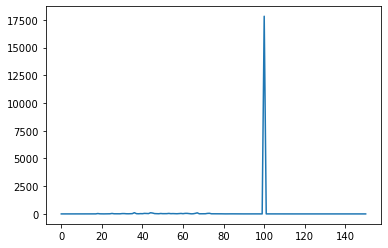

In [17]:
metrics = m.fit(train_val_df,
                freq="D",
                progress="plot")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


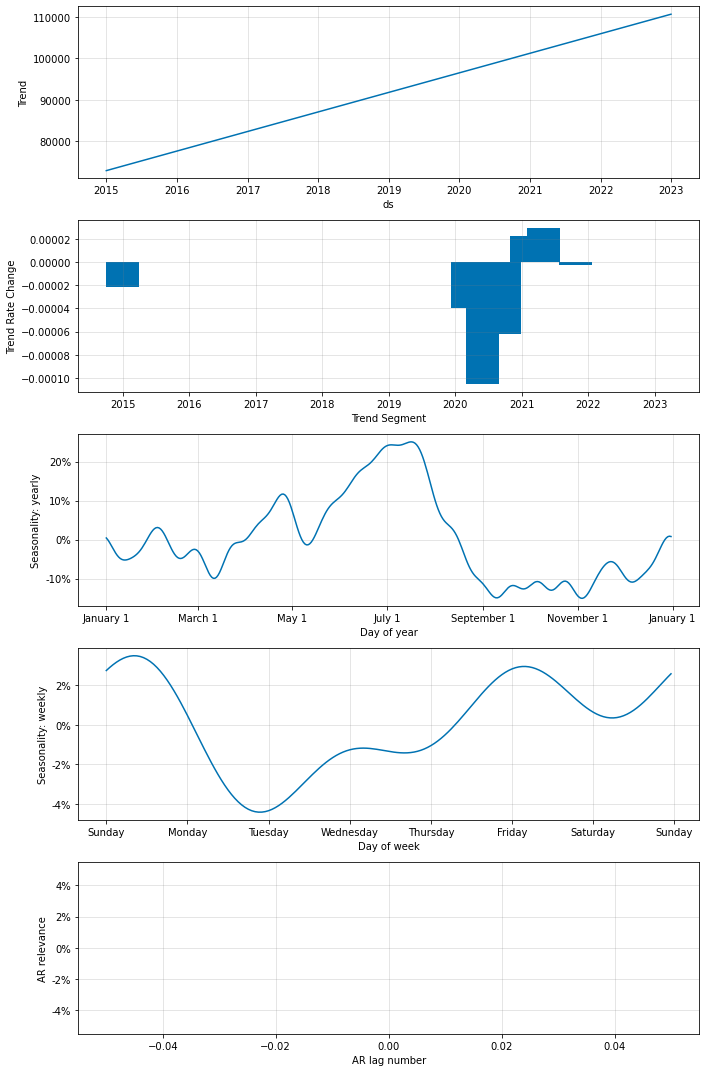

In [18]:
fig_param = m.plot_parameters()

In [19]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [20]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-12-31')]

,ds,y,covid_1,covid_2,covid_3,covid_4,No_int,Labor,Lunar,Summer,new_year
2922,2023-01-01,NaN,0,0,0,0,0,0,0,0,1
2923,2023-01-02,NaN,0,0,0,0,0,0,0,0,0
2924,2023-01-03,NaN,0,0,0,0,0,0,0,0,0
2925,2023-01-04,NaN,0,0,0,0,0,0,0,0,0
2926,2023-01-05,NaN,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3281,2023-12-26,NaN,0,0,0,0,0,0,0,0,0
3282,2023-12-27,NaN,0,0,0,0,0,0,0,0,0
3283,2023-12-28,NaN,0,0,0,0,0,0,0,0,0
3284,2023-12-29,NaN,0,0,0,0,0,0,0,0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


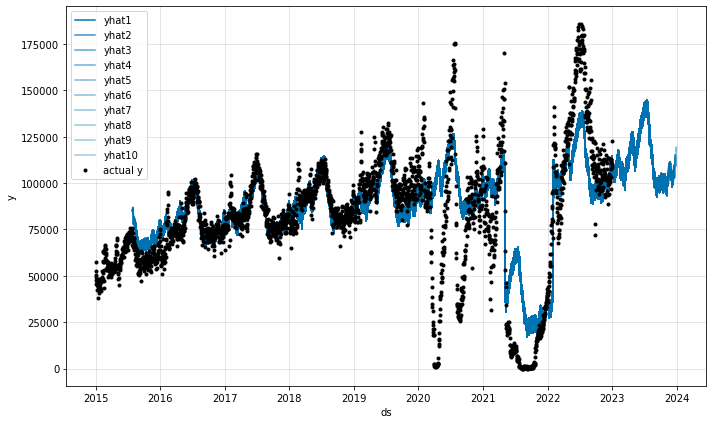

In [21]:
forecast = m.predict(future, decompose = True)
fig = m.plot(forecast)

In [22]:
#Consolidate forecast result
for i in forecast.filter(regex= ('yhat')).columns[1:]:
    forecast['yhat1'].update(forecast.pop(i))
for i in forecast.filter(regex= ('ar\d')).columns[1:]:
    forecast['ar1'].update(forecast.pop(i))

In [23]:
forecast.update(forecast[['ds','yhat1']].merge(dom, 'left','ds'))

In [24]:
forecast

,ds,y,yhat1,ar1,trend,season_yearly,season_weekly,events_additive,events_multiplicative,event_Labor,event_Lunar,event_No_int,event_Summer,event_covid_1,event_covid_2,event_covid_3,event_covid_4,event_new_year
0,2015-01-01,"52,356",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,"47,811",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,"49,555",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,"57,680",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,"50,193",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,2023-12-27,NaN,"113,502",0,"115,385",-428,"-1,455",0,0,0,0,0,0,0,0,0,0,0
3283,2023-12-28,NaN,"114,422",0,"115,398",236,"-1,211",0,0,0,0,0,0,0,0,0,0,0
3284,2023-12-29,NaN,"119,361",0,"115,411",707,"3,244",0,0,0,0,0,0,0,0,0,0,0
3285,2023-12-30,NaN,"117,110",0,"115,424",958,728,0,0,0,0,0,0,0,0,0,0,0


In [25]:
forecast.to_excel('forecast.xlsx')